## Research Objective

In this research project I seek to answer the following question: which politicians, policies, ideologies, and group interests are considered “economically populist” in the media? 

I will analyze newspaper data sourced from ProQuest TDM Studio over time to answer this question as part of my ongoing research agenda. ProQuest TDM Studio is a platform for text and data mining that allows researchers to analyze large-scale datasets from ProQuest’s collection of scholarly articles, newspapers, dissertations, and other content. It provides access to licensed materials in structured formats like .xml, enabling advanced computational analysis.

## Creating the dataset in Proquest TDM Studio

I created a corpus of 14,866 newspaper articles that reference economic populism by entering the following search query in ProQuest TDM Studio: "{economic populism}" OR "{economic populist}" OR "{economically populist}". Because many of these data sources are subject to strict licensure agreements, I had to create my dataset from this corpus of articles within ProQuest TDM Studio's Jupyter Notebook interface before exporting my dataset with limited original text for analysis on my own computer. I parsed each XML file in my dataset for metadata such as the title, date, publisher, and text of the article. I was not able to export the entirety of each article's original text due to copyright restrictions, so I created a new variable "sent_of_interest" to store all sentences containing the phrase "economic populism" as well as a few sentences before and after for context. I used the following code to create my dataset:

In [ ]:
import os
from tqdm import tqdm
import numpy as np
from datetime import datetime
import json
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import pandas as pd

# re-enable tdqm in pandas
tqdm.pandas()

corpus = '/home/ec2-user/SageMaker/data/econ_pop_over_time/'

# read in files
input_files = os.listdir(corpus)

In [ ]:
# gather text from articles to add to data frame

def strip_html_tags(text):
    ''' strip HTML tags from text portion '''
    stripped = BeautifulSoup(text, 'html.parser').get_text().replace('\\', '').strip()
    return stripped

# split text into sentences using regex (nltk is is difficult to work with in TDM Studio's Python interface)
def split_into_sentences(text):
    ''' split text into sentences using regex '''
    # replace common abbreviations or titles with a unique marker so that regex doesn't detect sentence punctuation
    text = re.sub(r'\b(Mr|Mrs|Ms|Dr|Prof|Jr|Sr|St|e\.g|i\.e|etc)\.', r'\1<MARKER>', text)
    # split text by sentence-ending punctuation
    sentences = re.split(r'(?<=\.|\?)\s', text)
    # after splitting, replace marker back with the original abbreviation
    sentences = [sentence.replace('<MARKER>', '.') for sentence in sentences]
    # return list of sentences
    return sentences

# retrieve metadata from XML documents
def getxmlcontent(corpus, file, strip_html = True, split_sentences = True):
    ''' retrieve metadata from XML documents '''
    try:
        # initialize variables
        goid = None
        title = None
        date = None
        publisher = None
        sourcetype = None
        text = None

        # parse XML file using built-in ElementTree module
        tree = ET.parse(corpus + file)
        root = tree.getroot()

        # extract GOID
        if root.find('.//GOID') is not None:
            goid = root.find('.//GOID').text

        # extract Title
        if root.find('.//Title') is not None:
            title = root.find('.//Title').text

        # extract Date
        if root.find('.//NumericDate') is not None:
            date = root.find('.//NumericDate').text

        # extract Publisher Name
        if root.find('.//PublisherName') is not None:
            publisher = root.find('.//PublisherName').text

        # extract Source Type
        if root.find('.//SourceRollupType') is not None:
            sourcetype = root.find('.//SourceRollupType').text

        # extract Text
        if root.find('.//Text') is not None:
            text = root.find('.//Text').text

        # strip html from text 
        if text is not None and strip_html:
            text = strip_html_tags(text)

        # split text into sentences
        if text is not None and split_sentences:
            text = split_into_sentences(text)

    except Exception as e:
        print(f"Error while parsing file {file}: {e}")

    # return extracted metadata
    return goid, title, date, publisher, sourcetype, text

In [ ]:
# create empty lists 
goid_list = []
title_list = []
date_list = []
publisher_list = []
sourcetype_list = []
text_list = []

# parse files and add data to lists
for file in input_files:
    
    # retrieve metadata
    goid, title, date, publisher, sourcetype, text = getxmlcontent(corpus, file, strip_html = True)

    # store metadata to lists
    goid_list.append(goid)
    title_list.append(title)
    date_list.append(date)
    publisher_list.append(publisher)
    sourcetype_list.append(sourcetype)
    text_list.append(text)

In [ ]:
df = pd.DataFrame({'GOID': goid_list, 'Title': title_list, 'Date': date_list, 'Publisher': publisher_list, 'Sourcetype': sourcetype_list, 'Text': text_list})

In [ ]:
# define key terms related to economic populism
search_terms = ['economic populism', 'economically populist', 'economic populist']

In [ ]:
# extract sentences that contain the search term (and 3 sentences on either side to add context)
def extract_sentence_with_neighbors(sentences, search_terms):
    ''' extract sentences of interest'''
    if not isinstance(sentences, list): # ensure sentences is a list
        return None

    # interate through each sentence in the list
    for i, sentence in enumerate(sentences):
        # check if any of the search terms appear in the sentence
        if any(term in sentence.lower() for term in search_terms):
            # get the previous 3 sentences (if they exist)
            prev_sentences = sentences[i-3:i] if i > 2 else sentences[:i]
            # get the subsequent 3 sentences (if they exist)
            next_sentences = sentences[i+1:i+4] if i < len(sentences) - 3 else sentences[i+1:]

            # concatenate the previous, current, and next sentences
            result = ''.join(prev_sentences + [sentence] + next_sentences).strip()
            return result

    # if no sentence contains the search terms, return None
    return None

# apply the function to the dataframe
df['sent_of_interest'] = df['Text'].apply(lambda x: extract_sentence_with_neighbors(x, search_terms)) 

In [ ]:
# remove 'text" column from df to avoid copyright infringement/data limits
df2 = df.drop(columns = ['Text'])

# export data - code from TDM Studios guidebook
df2.to_csv('output.csv', index = False)
data_to_export = '/home/ec2-user/SageMaker/data/output.csv'
!aws s3 cp $data_to_export s3://pq-tdm-studio-results/tdm-ale-data/a2059/results/

## Clean dataset

I now have a dataset in CSV file format ready to upload into my Jupyter notebook. However, I want to clean my dataset by removing certain types of sources. I also limit my data to articles written between 2010 and the present. I limit my article to this time frame because I am interested in the emergence and convergence of modern US intraparty factions related to the events of the Global Financial Crisis and the subsequent rise of Occupy Wall Street on the left and the Tea Party on the right. 

In [85]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('tdmscrape.csv')
df.head()

,Unnamed: 0,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype
0,1,8.481189e+08,THE 2008 CAMPAIGN: The Democrats,2007-12-19,New York Times Company,NaN,NaN
1,2,2.920162e+09,A test for Clinton,1993-02-15,"Boston Globe Media Partners, LLC",NaN,Newspapers
2,3,2.948584e+09,Three Faces of Populism in Current Switzerland...,2017-12-01,NaN,NaN,Scholarly Journals
3,4,3.301065e+08,Victorious Kerry ponders running mate:,2004-03-04,Postmedia Network Inc.,Mr. Kerry is not expected to make a quick deci...,Newspapers
4,5,1.841723e+09,An ambivalent relationship,2016-11-03,Arkansas Times,"Too, the electoral pattern across the country ...",Newspapers


In [87]:
len(df)

14868

In [89]:
# Remove the column named 'Unnamed: 0'
df = df.drop(columns=['Unnamed: 0'])

In [23]:
# Count occurrences of each value in the 'Sourcetype' column
publisher_counts = df['Sourcetype'].value_counts()
print(publisher_counts)

Sourcetype
Newspapers            7785
Web Resources         2083
Scholarly Journals    1009
Other Sources          823
Magazines              736
Transcripts             88
Multimedia               8
Books                    3
Name: count, dtype: int64


In [91]:
# Remove scholarly journals and books from data
df = df[~df['Sourcetype'].isin(['Scholarly Journals', 'Books'])]

In [43]:
# Count occurrences of each value in the 'Publisher' column
publisher_counts = df['Publisher'].value_counts()
print(publisher_counts.head(15))

Publisher
New York Times Company                                    913
WP Company LLC d/b/a The Washington Post                  852
Gannett Media Corp                                        670
Dow Jones & Company Inc.                                  556
News Bites Pty Ltd                                        389
POLITICO LLC                                              332
ContentEngine LLC, a Florida limited liability company    309
ProQuest Dissertations & Theses                           304
Postmedia Network Inc.                                    270
Tribune Publishing Company, LLC                           225
Newstex                                                   207
Los Angeles Times Communications LLC                      194
The Economist Intelligence Unit N.A., Incorporated        174
Disco Digital Media, Inc.                                 157
Guardian News & Media Limited                             154
Name: count, dtype: int64


In [93]:
# Remove dissertations & theses from data
df = df[~df['Publisher'].isin(['ProQuest Dissertations & Theses'])]

In [95]:
# Extract the first 4 characters of 'Date' and convert them to integers
def extract_year(date):
    ''' extract year from date '''
    try:
        # Ensure the first 4 characters are digits (valid year)
        year = str(date)[:4]
        if year.isdigit():
            return int(year)
        else:
            return None  # or you can return a default year (e.g., 2000)
    except Exception as e:
        return None  # Handle other potential errors

# Add a new column 'Year'
df['Year'] = df['Date'].apply(extract_year)

# Filter rows where 'Year' >= 2010
df = df[df['Year'] >= 2010]

# Ensure 'Year' column has integer type (no decimals)
df['Year'] = df['Year'].astype(int)

# Display the updated DataFrame
df.head()

,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype,Year
4,1.841723e+09,An ambivalent relationship,2016-11-03,Arkansas Times,"Too, the electoral pattern across the country ...",Newspapers,2016
5,2.938226e+09,MERCER LLC - THE LATEST INDUSTRY NEWS INCLUDIN...,2024-03-07,News Bites Pty Ltd,Sabre-rattling against the eye-watering prices...,Newspapers,2024
6,2.046678e+09,The populist 1 percenter,2015-05-05,POLITICO LLC,"In 2009, the convict killed four police office...",Web Resources,2015
8,1.785774e+09,Indiana Economy Offers Caution and Inspiration...,2016-05-01,New York Times Company,"""And you know what? They have to pay a consequ...",NaN,2016
10,1.731729e+09,Warren's clout in party is tested as Clinton s...,2015-11-09,Los Angeles Times Communications LLC,"As she bides her time, centrists within Democr...",Newspapers,2015


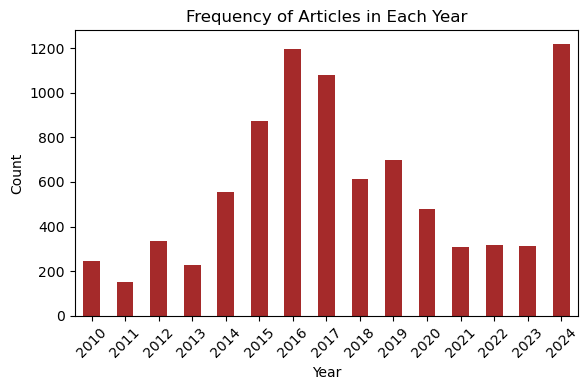

In [67]:
# Plot bar chart of all articles 2010-present
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
df['Year'].value_counts().sort_index().plot(kind='bar', color='brown')

# Customize the plot
plt.title('Frequency of Articles in Each Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## Using Claude to perform textual analysis

In the following section, I will use Claude to categorize the text contained in each article - a task that I would have traditionally reserved for an undergraduate RA. First, I have Claude determine which of the following categories the article uses the phrase "economic populism" in relation to: people, policy, groups, and/or ideology. Then, I break my dataset down into smaller datasets for each category for more in-depth analysis.

I am only able to analyze articles for which I was able to obtain text from ProQuest TDM Studio. Therefore, I will remove all rows of the data for which "sent_of_interest" is NaN before conducting further analysis. I am left with 7,273 articles in total.

In [97]:
# Remove rows where 'sent_of_interest' is NaN - cannot analyze
df_2 = df.dropna(subset=['sent_of_interest'])

In [101]:
len(df_2)

7273

In [103]:
# Save DataFrame to a CSV file as a backup
df_2.to_csv('final-proj-text-analysis.csv', index=False)

In [8]:
import pandas as pd

# Read the CSV file
df_2 = pd.read_csv('final-proj-text-analysis.csv')
df_2.head()

,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype,Year
0,1.841723e+09,An ambivalent relationship,2016-11-03,Arkansas Times,"Too, the electoral pattern across the country ...",Newspapers,2016
1,2.938226e+09,MERCER LLC - THE LATEST INDUSTRY NEWS INCLUDIN...,2024-03-07,News Bites Pty Ltd,Sabre-rattling against the eye-watering prices...,Newspapers,2024
2,2.046678e+09,The populist 1 percenter,2015-05-05,POLITICO LLC,"In 2009, the convict killed four police office...",Web Resources,2015
3,1.785774e+09,Indiana Economy Offers Caution and Inspiration...,2016-05-01,New York Times Company,"""And you know what? They have to pay a consequ...",NaN,2016
4,1.731729e+09,Warren's clout in party is tested as Clinton s...,2015-11-09,Los Angeles Times Communications LLC,"As she bides her time, centrists within Democr...",Newspapers,2015


In [10]:
import anthropic
from time import sleep

api_key= # removed

# Get Claude's classification 

model_name = 'claude-3-5-sonnet-20241022'

### Categorization of "economic populism"

In [15]:
def categorize_with_claude(df, text_column, api_key, batch_size=1, delay=.2):
    """
    Categorizes text using Claude API and adds results to a new column.
    
    Args:
        df (pandas.DataFrame): Input dataframe
        text_column (str): Name of column containing text to analyze
        api_key (str): Anthropic API key
        batch_size (int): Number of requests to process before pausing
        delay (int): Seconds to pause between batches
        
    Returns:
        pandas.DataFrame: DataFrame with new 'claude_category' column
    """
    
    instructions = """You are an AI trained to categorize newspaper articles into one of four categories. Please categorize the text into one or more of the following categories based on its content:
1. 'person': A person or multiple people are described as being an economic populist.
2. 'policy': Mentions of specific policies or proposals tied to economic populism.
3. 'group': Refers to political parties, factions, movements, or groups of people associated with economic populism.
4. 'ideology': Describes economic populism as an ideological belief system, such as beliefs about protecting the middle class, workers' rights, opposing corporate greed, or opposing the establishment.

If the text mentions more than one category, return all relevant categories. If none of the categories apply, return 'none'. 
If the text is primarily about a country other than the United States of America, return 'foreign'.

IMPORTANT: Return ONLY the categories in your response, separated by commas with no additional explanation or commentary."""

   # Initialize Anthropic client
    client = anthropic.Anthropic(api_key=api_key)
    
    # Create empty list to store categorizations
    categorizations = []
    
    # Process texts in batches
    for i, text in enumerate(df[text_column]):
        try:
            # Combine instructions and text
            combined_prompt = instructions + "\n\nPlease proceed with the categorization based on the content of the provided article:\n" + text
            
            # Get Claude's categorization
            completion = client.messages.create(
                model='claude-3-5-sonnet-20241022',
                max_tokens=10,
                temperature=0,
                messages=[
                    {"role": "user", "content": combined_prompt}
                ]
            )
            
            # Extract and clean the categorization
            category = completion.content[0].text.strip().replace('"', '')
            categorizations.append(category)

            # Pause after every batch_size requests
            if (i + 1) % batch_size == 0:
                print(f"Processed {i + 1} texts. Pausing for {delay} second(s)...")
                sleep(delay)
                
        except Exception as e:
            print(f"Error processing text {i}: {str(e)}")
            categorizations.append("error")
            
    # Add categorizations as new column
    df['claude_category'] = categorizations

    return df

In [17]:
df_3 = categorize_with_claude(df_2, 'sent_of_interest', api_key, batch_size=1, delay=.2)

Processed 1 texts. Pausing for 0.2 second(s)...
Processed 2 texts. Pausing for 0.2 second(s)...
Processed 3 texts. Pausing for 0.2 second(s)...
Processed 4 texts. Pausing for 0.2 second(s)...
Processed 5 texts. Pausing for 0.2 second(s)...
Processed 6 texts. Pausing for 0.2 second(s)...
Processed 7 texts. Pausing for 0.2 second(s)...
Processed 8 texts. Pausing for 0.2 second(s)...
Processed 9 texts. Pausing for 0.2 second(s)...
Processed 10 texts. Pausing for 0.2 second(s)...
Processed 11 texts. Pausing for 0.2 second(s)...
Processed 12 texts. Pausing for 0.2 second(s)...
Processed 13 texts. Pausing for 0.2 second(s)...
Processed 14 texts. Pausing for 0.2 second(s)...
Processed 15 texts. Pausing for 0.2 second(s)...
Processed 16 texts. Pausing for 0.2 second(s)...
Processed 17 texts. Pausing for 0.2 second(s)...
Processed 18 texts. Pausing for 0.2 second(s)...
Processed 19 texts. Pausing for 0.2 second(s)...
Processed 20 texts. Pausing for 0.2 second(s)...
Processed 21 texts. Pausing f

In [21]:
df_3.head()

,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype,Year,claude_category
0,1.841723e+09,An ambivalent relationship,2016-11-03,Arkansas Times,"Too, the electoral pattern across the country ...",Newspapers,2016,"person, ideology"
1,2.938226e+09,MERCER LLC - THE LATEST INDUSTRY NEWS INCLUDIN...,2024-03-07,News Bites Pty Ltd,Sabre-rattling against the eye-watering prices...,Newspapers,2024,"ideology, person"
2,2.046678e+09,The populist 1 percenter,2015-05-05,POLITICO LLC,"In 2009, the convict killed four police office...",Web Resources,2015,"person, ideology"
3,1.785774e+09,Indiana Economy Offers Caution and Inspiration...,2016-05-01,New York Times Company,"""And you know what? They have to pay a consequ...",NaN,2016,"person, ideology"
4,1.731729e+09,Warren's clout in party is tested as Clinton s...,2015-11-09,Los Angeles Times Communications LLC,"As she bides her time, centrists within Democr...",Newspapers,2015,"person, ideology"


In [37]:
# DF of rows where claude_category is not "error"
df_3_1 = df_3[df_3['claude_category'] != "error"]

# DF of rows where claude_category is "error"
df_3_2 = df_3[df_3['claude_category'] == "error"]

# Drop claude_category
df_3_2 = df_3_2.drop(columns=['claude_category'])

In [39]:
# Recategorize rows where claude_category is "error"
df_3_3 = categorize_with_claude(df_3_2, 'sent_of_interest', api_key, batch_size=1, delay=.2)

Processed 1 texts. Pausing for 0.2 second(s)...
Processed 2 texts. Pausing for 0.2 second(s)...
Processed 3 texts. Pausing for 0.2 second(s)...
Processed 4 texts. Pausing for 0.2 second(s)...
Processed 5 texts. Pausing for 0.2 second(s)...
Processed 6 texts. Pausing for 0.2 second(s)...
Processed 7 texts. Pausing for 0.2 second(s)...
Processed 8 texts. Pausing for 0.2 second(s)...
Processed 9 texts. Pausing for 0.2 second(s)...
Processed 10 texts. Pausing for 0.2 second(s)...
Processed 11 texts. Pausing for 0.2 second(s)...
Processed 12 texts. Pausing for 0.2 second(s)...
Processed 13 texts. Pausing for 0.2 second(s)...
Processed 14 texts. Pausing for 0.2 second(s)...
Processed 15 texts. Pausing for 0.2 second(s)...
Processed 16 texts. Pausing for 0.2 second(s)...
Processed 17 texts. Pausing for 0.2 second(s)...
Processed 18 texts. Pausing for 0.2 second(s)...
Processed 19 texts. Pausing for 0.2 second(s)...
Processed 20 texts. Pausing for 0.2 second(s)...
Processed 21 texts. Pausing f

In [63]:
# Combine df_3_1 and df_3_3
df_3_4 = pd.concat([df_3_1, df_3_3], ignore_index=True)

df_3_4.head()

,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype,Year,claude_category
0,1.841723e+09,An ambivalent relationship,2016-11-03,Arkansas Times,"Too, the electoral pattern across the country ...",Newspapers,2016,"person, ideology"
1,2.938226e+09,MERCER LLC - THE LATEST INDUSTRY NEWS INCLUDIN...,2024-03-07,News Bites Pty Ltd,Sabre-rattling against the eye-watering prices...,Newspapers,2024,"ideology, person"
2,2.046678e+09,The populist 1 percenter,2015-05-05,POLITICO LLC,"In 2009, the convict killed four police office...",Web Resources,2015,"person, ideology"
3,1.785774e+09,Indiana Economy Offers Caution and Inspiration...,2016-05-01,New York Times Company,"""And you know what? They have to pay a consequ...",NaN,2016,"person, ideology"
4,1.731729e+09,Warren's clout in party is tested as Clinton s...,2015-11-09,Los Angeles Times Communications LLC,"As she bides her time, centrists within Democr...",Newspapers,2015,"person, ideology"


In [65]:
# Save DataFrame to a CSV file as a backup
df_3_4.to_csv('final-proj-categories.csv', index=False)

In [79]:
# Check to see how many rows are not related to the US
print(df_3_4['claude_category'].str.contains('foreign').sum())

# Remove these rows from the dataframe
df_3_5 = df_3_4[~df_3_4['claude_category'].str.contains('foreign', na=False)]
print(len(df_3_5))

1676
5597


In [83]:
# Create separate dataframes based on the Claude-assigned category and save each to a CSV file

# Filter rows where 'claude_category' contains the string 'person'
cat_person = df_3_5[df_3_5['claude_category'].str.contains('person')]
cat_person.to_csv('final-proj-cat-person.csv', index=False)
print(len(cat_person))

# Filter rows where 'claude_category' contains the string 'policy'
cat_policy = df_3_5[df_3_5['claude_category'].str.contains('policy')]
cat_policy.to_csv('final-proj-cat-policy.csv', index=False)
print(len(cat_policy))

# Filter rows where 'claude_category' contains the string 'group'
cat_group = df_3_5[df_3_5['claude_category'].str.contains('group')]
cat_group.to_csv('final-proj-cat-group.csv', index=False)
print(len(cat_group))

# Filter rows where 'claude_category' contains the string 'ideology'
cat_ideology = df_3_5[df_3_5['claude_category'].str.contains('ideology')]
cat_ideology.to_csv('final-proj-cat-ideology.csv', index=False)
print(len(cat_ideology))

4795
1721
1196
4162


### Sub-categorization of people as they pertain to "economic populism"

In [113]:
def categorize_people(df, text_column, api_key, batch_size=1, delay=.2):
    """
    Categorizes text using Claude API and adds results to a new column.
    
    Args:
        df (pandas.DataFrame): Input dataframe
        text_column (str): Name of column containing text to analyze
        api_key (str): Anthropic API key
        batch_size (int): Number of requests to process before pausing
        delay (int): Seconds to pause between batches
        
    Returns:
        pandas.DataFrame: DataFrame with new 'people' column
    """
    
    instructions = """You are an AI tasked with identifying individuals described as economic populists in newspaper articles. 
Please analyze provided text and identify only individuals who are described as economic populists or associated with economic populism.

INCLUDE only names when the person is characterized as being an economic populist or promoting an economically populist agenda, policies, or ideology.

EXCLUDE names when the person is mentioned in the same article but not linked to economic populism.

When a person is explicitly described as a "faux populist" or their association with economic populism is questioned, include their name with the word "not" in front.
For example, if Donald Trump is referred to as a "faux populist", the output should be ['not Donald Trump'].

NAME FORMATTING:
Use full names (first and last)
Maintain consistent naming across articles (e.g., always use "Bernie Sanders" instead of "Senator Sanders")
Present names in a comma-separated list within square brackets

EXAMPLE OUTPUTS:
Single name: ['Bernie Sanders']
Multiple names: ['Elizabeth Warren', 'Bernie Sanders']

IMPORTANT: Return ONLY the list of names without any additional explanation, commentary, or analysis."""

    # Initialize Anthropic client
    client = anthropic.Anthropic(api_key=api_key)
    
    # Create empty list to store categorizations
    categorizations = []
    
    # Process texts in batches
    for i, text in enumerate(df[text_column]):
        try:
            # Combine instructions and text
            combined_prompt = instructions + "\n\nPlease proceed with the categorization based on the content of the provided article:\n" + text
            
            # Get Claude's categorization
            completion = client.messages.create(
                model='claude-3-5-sonnet-20241022',
                max_tokens=15,
                temperature=0,
                messages=[
                    {"role": "user", "content": combined_prompt}
                ]
            )
            
            # Extract and clean the categorization
            category = completion.content[0].text.strip().replace('"', '')
            categorizations.append(category)
            
            # Pause after every batch_size requests
            if (i + 1) % batch_size == 0:
                print(f"Processed {i + 1} texts. Pausing for {delay} second(s)...")
                sleep(delay)
                
        except Exception as e:
            print(f"Error processing text {i}: {str(e)}")
            categorizations.append("error")
            
    # Add categorizations as new column
    df['people'] = categorizations
    
    return df

In [115]:
cat_person_2 = categorize_people(cat_person, 'sent_of_interest', api_key, batch_size=1, delay=.2)

Processed 1 texts. Pausing for 0.2 second(s)...
Processed 2 texts. Pausing for 0.2 second(s)...
Processed 3 texts. Pausing for 0.2 second(s)...
Processed 4 texts. Pausing for 0.2 second(s)...
Processed 5 texts. Pausing for 0.2 second(s)...
Processed 6 texts. Pausing for 0.2 second(s)...
Processed 7 texts. Pausing for 0.2 second(s)...
Processed 8 texts. Pausing for 0.2 second(s)...
Processed 9 texts. Pausing for 0.2 second(s)...
Processed 10 texts. Pausing for 0.2 second(s)...
Processed 11 texts. Pausing for 0.2 second(s)...
Processed 12 texts. Pausing for 0.2 second(s)...
Processed 13 texts. Pausing for 0.2 second(s)...
Processed 14 texts. Pausing for 0.2 second(s)...
Processed 15 texts. Pausing for 0.2 second(s)...
Processed 16 texts. Pausing for 0.2 second(s)...
Processed 17 texts. Pausing for 0.2 second(s)...
Processed 18 texts. Pausing for 0.2 second(s)...
Processed 19 texts. Pausing for 0.2 second(s)...
Processed 20 texts. Pausing for 0.2 second(s)...
Processed 21 texts. Pausing f

C:\Users\fknia\AppData\Local\Temp\ipykernel_10200\998177502.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['people'] = categorizations


In [117]:
cat_person_2.head()

,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype,Year,claude_category,people
0,1.841723e+09,An ambivalent relationship,2016-11-03,Arkansas Times,"Too, the electoral pattern across the country ...",Newspapers,2016,"person, ideology",['Bill Clinton']
1,2.938226e+09,MERCER LLC - THE LATEST INDUSTRY NEWS INCLUDIN...,2024-03-07,News Bites Pty Ltd,Sabre-rattling against the eye-watering prices...,Newspapers,2024,"ideology, person",['Andrew Jackson']
2,2.046678e+09,The populist 1 percenter,2015-05-05,POLITICO LLC,"In 2009, the convict killed four police office...",Web Resources,2015,"person, ideology",['Mike Huckabee']
3,1.785774e+09,Indiana Economy Offers Caution and Inspiration...,2016-05-01,New York Times Company,"""And you know what? They have to pay a consequ...",NaN,2016,"person, ideology",['Bernie Sanders']
4,1.731729e+09,Warren's clout in party is tested as Clinton s...,2015-11-09,Los Angeles Times Communications LLC,"As she bides her time, centrists within Democr...",Newspapers,2015,"person, ideology",['Elizabeth Warren']


In [119]:
# DF of rows where 'people' is not "error"
cat_person_2_1 = cat_person_2[cat_person_2['people'] != "error"]

# DF of rows where 'people' is "error"
cat_person_2_2 = cat_person_2[cat_person_2['people'] == "error"]

In [121]:
# Drop 'people' for error rows
cat_person_2_2 = cat_person_2_2.drop(columns=['people'])

# Recategorize rows where 'people' is "error"
cat_person_2_3 = categorize_people(cat_person_2_2, 'sent_of_interest', api_key, batch_size=1, delay=.2)

Processed 1 texts. Pausing for 0.2 second(s)...
Processed 2 texts. Pausing for 0.2 second(s)...
Processed 3 texts. Pausing for 0.2 second(s)...
Processed 4 texts. Pausing for 0.2 second(s)...
Processed 5 texts. Pausing for 0.2 second(s)...
Processed 6 texts. Pausing for 0.2 second(s)...
Processed 7 texts. Pausing for 0.2 second(s)...
Processed 8 texts. Pausing for 0.2 second(s)...
Processed 9 texts. Pausing for 0.2 second(s)...
Processed 10 texts. Pausing for 0.2 second(s)...
Processed 11 texts. Pausing for 0.2 second(s)...


In [125]:
# Combine cat_person_2_1 and cat_person_2_3
cat_person_2_4 = pd.concat([cat_person_2_1, cat_person_2_3], ignore_index=True)

# Save a back-up
cat_person_2_4.to_csv('final-proj-cat-person.csv', index=False)

cat_person_2_4.head()

,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype,Year,claude_category,people
0,1.841723e+09,An ambivalent relationship,2016-11-03,Arkansas Times,"Too, the electoral pattern across the country ...",Newspapers,2016,"person, ideology",['Bill Clinton']
1,2.938226e+09,MERCER LLC - THE LATEST INDUSTRY NEWS INCLUDIN...,2024-03-07,News Bites Pty Ltd,Sabre-rattling against the eye-watering prices...,Newspapers,2024,"ideology, person",['Andrew Jackson']
2,2.046678e+09,The populist 1 percenter,2015-05-05,POLITICO LLC,"In 2009, the convict killed four police office...",Web Resources,2015,"person, ideology",['Mike Huckabee']
3,1.785774e+09,Indiana Economy Offers Caution and Inspiration...,2016-05-01,New York Times Company,"""And you know what? They have to pay a consequ...",NaN,2016,"person, ideology",['Bernie Sanders']
4,1.731729e+09,Warren's clout in party is tested as Clinton s...,2015-11-09,Los Angeles Times Communications LLC,"As she bides her time, centrists within Democr...",Newspapers,2015,"person, ideology",['Elizabeth Warren']


### Sub-categorization of policies as they pertain to "economic populism"

In [171]:
def categorize_policy(df, text_column, api_key, batch_size=1, delay=.2):
    """
    Categorizes text using Claude API and adds results to a new column.
    
    Args:
        df (pandas.DataFrame): Input dataframe
        text_column (str): Name of column containing text to analyze
        api_key (str): Anthropic API key
        batch_size (int): Number of requests to process before pausing
        delay (int): Seconds to pause between batches
        
    Returns:
        pandas.DataFrame: DataFrame with new 'policy' column
    """
    
    instructions = """You are an AI tasked with identifying policies described as economically populist in newspaper articles. 
Please analyze provided text and identify only policies that are described as economically populist or associated with economic populism.

INCLUDE only policies that are characterized as being economically populist or promoting an economically populist agenda or ideology.

EXCLUDE policies that are mentioned in the same article but are not linked to economic populism.

EXAMPLE TEXT: Sen. Bernie Sanders brought his presidential campaign to a Super Tuesday state on Tuesday, telling supporters there's "a lot of pain" touching every demographic in the country. 
The Vermont independent said his economic populist agenda aims to pay workers a higher minimum wage, provide pay equity for women, and reform the criminal justice, immigration and campaign finance systems. 
EXAMPLE OUTPUT: ['higher minimum wage', 'pay equity for women', 'criminal justice reform', 'immigration reform', 'campaign finance reform']

Some potential policies (list not exhaustive): higher minimum wage, protecting/increasing Social Security, paid family leave, Medicare for All, trade protectionism,
infrastructure spending, banking/Wall Street/corporate reform, regulation of drug prices, free public college, campaign finance reform, taxing corporations/the rich,
anti-trust, child tax credit, tax cuts, restricting immigration, healthcare reform, workers' rights/labor protections

FORMATTING:
Maintain consistent naming across articles (e.g., always use "trade protectionism" instead of "anti-free trade" or "trade skeptical")
Present policies in a comma-separated list within square brackets. 

IMPORTANT: Return ONLY the list of policies without any additional explanation, commentary, or analysis."""

    # Initialize Anthropic client
    client = anthropic.Anthropic(api_key=api_key)
    
    # Create empty list to store categorizations
    categorizations = []
    
    # Process texts in batches
    for i, text in enumerate(df[text_column]):
        try:
            # Combine instructions and text
            combined_prompt = instructions + "\n\nPlease proceed with the categorization based on the content of the provided article:\n" + text
            
            # Get Claude's categorization
            completion = client.messages.create(
                model='claude-3-5-sonnet-20241022',
                max_tokens=40,
                temperature=0,
                messages=[
                    {"role": "user", "content": combined_prompt}
                ]
            )
            
            # Extract and clean the categorization
            category = completion.content[0].text.strip().replace('"', '')
            categorizations.append(category)
            
            # Pause after every batch_size requests
            if (i + 1) % batch_size == 0:
                print(f"Processed {i + 1} texts. Pausing for {delay} second(s)...")
                sleep(delay)
                
        except Exception as e:
            print(f"Error processing text {i}: {str(e)}")
            categorizations.append("error")
            
    # Add categorizations as new column
    df['policy'] = categorizations
    
    return df               

In [173]:
cat_policy_2 = categorize_policy(cat_policy, 'sent_of_interest', api_key, batch_size=1, delay=.2)

Processed 1 texts. Pausing for 0.2 second(s)...
Processed 2 texts. Pausing for 0.2 second(s)...
Processed 3 texts. Pausing for 0.2 second(s)...
Processed 4 texts. Pausing for 0.2 second(s)...
Processed 5 texts. Pausing for 0.2 second(s)...
Processed 6 texts. Pausing for 0.2 second(s)...
Processed 7 texts. Pausing for 0.2 second(s)...
Processed 8 texts. Pausing for 0.2 second(s)...
Processed 9 texts. Pausing for 0.2 second(s)...
Processed 10 texts. Pausing for 0.2 second(s)...
Processed 11 texts. Pausing for 0.2 second(s)...
Processed 12 texts. Pausing for 0.2 second(s)...
Processed 13 texts. Pausing for 0.2 second(s)...
Processed 14 texts. Pausing for 0.2 second(s)...
Processed 15 texts. Pausing for 0.2 second(s)...
Processed 16 texts. Pausing for 0.2 second(s)...
Processed 17 texts. Pausing for 0.2 second(s)...
Processed 18 texts. Pausing for 0.2 second(s)...
Processed 19 texts. Pausing for 0.2 second(s)...
Processed 20 texts. Pausing for 0.2 second(s)...
Processed 21 texts. Pausing f

C:\Users\fknia\AppData\Local\Temp\ipykernel_10200\1149821505.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['policy'] = categorizations


In [175]:
# DF of rows where 'policy' is not "error"
cat_policy_2_1 = cat_policy_2[cat_policy_2['policy'] != "error"]

# DF of rows where 'policy' is "error"
cat_policy_2_2 = cat_policy_2[cat_policy_2['policy'] == "error"]

In [177]:
# Drop 'policy' for error rows
cat_policy_2_2 = cat_policy_2_2.drop(columns=['policy'])

# Recategorize rows where 'policy' is "error"
cat_policy_2_3 = categorize_policy(cat_policy_2_2, 'sent_of_interest', api_key, batch_size=1, delay=.2)

In [179]:
# Combine cat_policy_2_1 and cat_policy_2_3
cat_policy_2_4 = pd.concat([cat_policy_2_1, cat_policy_2_3], ignore_index=True)

# Save a back-up
cat_policy_2_4.to_csv('final-proj-cat-policy.csv', index=False)

cat_policy_2_4.head()

,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype,Year,claude_category,policy
0,1.432242e+09,The Morning Plum: Delusions and lies about Oba...,2013-09-13,WP Company LLC d/b/a The Washington Post,It looks like we may be heading for a public f...,Web Resources,2013,"person, policy, ideology","['universal prekindergarden', 'taxing the rich']"
1,2.043018e+09,Trump Caves to Drug Industry on Price Controls,2018-05-23,Creators Syndicate,It contained nothing that will threaten its en...,Newspapers,2018,"person, policy, ideology","['regulation of drug prices', 'healthcare refo..."
2,1.767618e+09,Bernie Sanders rallies supporters in Virginia,2016-02-24,Gannett Media Corp,-- Sen. Bernie Sanders brought his presidentia...,Newspapers,2016,"person, policy, ideology","['higher minimum wage', 'pay equity for women'..."
3,2.012882e+09,"In Indiana, tariffs blessing and curse",2018-03-12,Gannett Media Corp,Indiana's manufacturers have a different view....,Newspapers,2018,"person, policy",['trade protectionism']
4,1.697496e+09,Benzinga: How Donald Trump Is Outpacing The GO...,2015-07-21,Newstex,"According to Kaltbaum, he has highlighted ""75,...",Web Resources,2015,"person, policy, ideology","['tax reform', 'trade protectionism']"


### Sub-categorization of groups as they pertain to "economic populism"

In [151]:
def categorize_group(df, text_column, api_key, batch_size=1, delay=.2):
    """
    Categorizes text using Claude API and adds results to a new column.
    
    Args:
        df (pandas.DataFrame): Input dataframe
        text_column (str): Name of column containing text to analyze
        api_key (str): Anthropic API key
        batch_size (int): Number of requests to process before pausing
        delay (int): Seconds to pause between batches
        
    Returns:
        pandas.DataFrame: DataFrame with new 'group' column
    """
    
    instructions = """You are an AI tasked with identifying political parties, factions, movements, or groups of people described as economic populists in newspaper articles. 
Please analyze provided text and identify only groups who are described as economic populists or associated with economic populism.

INCLUDE only group names when the group is characterized as being an economic populist or promoting an economically populist agenda, policies, or ideology.

EXCLUDE group names when the group is mentioned in the same article but not linked to economic populism. EXCLUDE names of single individuals.

When a group is explicitly described as a "faux populist" or their association with economic populism is questioned, include their name with the word "not" in front.
For example, if the Republican Party is referred to as a "faux populist", the output should be ['not Republicans'].

GROUP NAME FORMATTING:
Maintain consistent naming across articles (e.g., always use "Republicans" instead of "Republican Party" or "GOP")
Present names in a comma-separated list within square brackets

EXAMPLE OUTPUTS:
Single name: ['blue-collar workers']
Multiple names: ['blue-collar workers', 'progressives', 'Democrats']

IMPORTANT: Return ONLY the list of group names without any additional explanation, commentary, or analysis."""

    # Initialize Anthropic client
    client = anthropic.Anthropic(api_key=api_key)
    
    # Create empty list to store categorizations
    categorizations = []
    
    # Process texts in batches
    for i, text in enumerate(df[text_column]):
        try:
            # Combine instructions and text
            combined_prompt = instructions + "\n\nPlease proceed with the categorization based on the content of the provided article:\n" + text
            
            # Get Claude's categorization
            completion = client.messages.create(
                model='claude-3-5-sonnet-20241022',
                max_tokens=20,
                temperature=0,
                messages=[
                    {"role": "user", "content": combined_prompt}
                ]
            )
            
            # Extract and clean the categorization
            category = completion.content[0].text.strip().replace('"', '')
            categorizations.append(category)
            
            # Pause after every batch_size requests
            if (i + 1) % batch_size == 0:
                print(f"Processed {i + 1} texts. Pausing for {delay} second(s)...")
                sleep(delay)
                
        except Exception as e:
            print(f"Error processing text {i}: {str(e)}")
            categorizations.append("error")
            
    # Add categorizations as new column
    df['group'] = categorizations
    
    return df

In [159]:
cat_group_2 = categorize_group(cat_group, 'sent_of_interest', api_key, batch_size=1, delay=.2)

Processed 1 texts. Pausing for 0.2 second(s)...
Processed 2 texts. Pausing for 0.2 second(s)...
Processed 3 texts. Pausing for 0.2 second(s)...
Processed 4 texts. Pausing for 0.2 second(s)...
Processed 5 texts. Pausing for 0.2 second(s)...
Processed 6 texts. Pausing for 0.2 second(s)...
Processed 7 texts. Pausing for 0.2 second(s)...
Processed 8 texts. Pausing for 0.2 second(s)...
Processed 9 texts. Pausing for 0.2 second(s)...
Processed 10 texts. Pausing for 0.2 second(s)...
Processed 11 texts. Pausing for 0.2 second(s)...
Processed 12 texts. Pausing for 0.2 second(s)...
Processed 13 texts. Pausing for 0.2 second(s)...
Processed 14 texts. Pausing for 0.2 second(s)...
Processed 15 texts. Pausing for 0.2 second(s)...
Processed 16 texts. Pausing for 0.2 second(s)...
Processed 17 texts. Pausing for 0.2 second(s)...
Processed 18 texts. Pausing for 0.2 second(s)...
Processed 19 texts. Pausing for 0.2 second(s)...
Processed 20 texts. Pausing for 0.2 second(s)...
Processed 21 texts. Pausing f

C:\Users\fknia\AppData\Local\Temp\ipykernel_10200\1665205282.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = categorizations


In [163]:
# DF of rows where 'group' is not "error"
cat_group_2_1 = cat_group_2[cat_group_2['group'] != "error"]

# DF of rows where 'group' is "error"
cat_group_2_2 = cat_group_2[cat_group_2['group'] == "error"]

In [167]:
# Drop 'group' for error rows
cat_group_2_2 = cat_group_2_2.drop(columns=['group'])

# Recategorize rows where 'group' is "error"
cat_group_2_3 = categorize_group(cat_group_2_2, 'sent_of_interest', api_key, batch_size=1, delay=.2)

In [169]:
# Combine cat_group_2_1 and cat_group_2_3
cat_group_2_4 = pd.concat([cat_group_2_1, cat_group_2_3], ignore_index=True)

# Save a back-up
cat_group_2_4.to_csv('final-proj-cat-group.csv', index=False)

cat_group_2_4.head()

,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype,Year,claude_category,people,group
0,1.851281e+09,Democrats Add Fresh Faces to Senate Banking Co...,2016-12-22,Dow Jones & Company Inc.,"Without Mr. Schumer, who some liberals view wa...",Newspapers,2016,"person, group, ideology",[],"['Democrats', 'progressives']"
1,1.841847e+09,Albania Country Risk Report - Q1 2017,2017-01-01,Fitch Solutions Group Limited,Political risks in developed markets (DM) have...,Other Sources,2017,"ideology, group",[],['anti-establishment movements']
2,3.113230e+09,PA. RACES SPARKING HISTORIC SPENDING NATION'S ...,2024-10-06,Pittsburgh Post - Gazette,"Another, WinSenate, has shelled out about $65 ...",Newspapers,2024,"group, ideology",['Donald Trump'],['blue-collar workers']
3,1.928357e+09,Rigid party strategies pave lane for an outsider,2017-08-13,Owensboro Messenger Inquirer,His media cheerleaders increasingly define con...,Newspapers,2017,"person, group, ideology",[],['Democrats']
4,3.126802e+09,'The backlash proves my point:' As Democrats e...,2024-11-12,"Boston Globe Media Partners, LLC",“But activists want there to be only one way t...,Newspapers,2024,"person, policy, group, ideology","['Elizabeth Warren', 'Bernie Sanders']","['progressives', 'working-class America']"


### Sub-categorization of ideologies as they pertain to "economic populism"

In [737]:
def categorize_ideology(df, text_column, api_key, batch_size=1, delay=.2):
    """
    Categorizes text using Claude API and adds results to a new column.
    
    Args:
        df (pandas.DataFrame): Input dataframe
        text_column (str): Name of column containing text to analyze
        api_key (str): Anthropic API key
        batch_size (int): Number of requests to process before pausing
        delay (int): Seconds to pause between batches
        
    Returns:
        pandas.DataFrame: DataFrame with new 'ideology' column
    """
    
    instructions = """You are an AI trained to categorize newspaper articles. Please categorize the text's primary usage of the term "economic populism" into one or more of the following categories:
1. 'workers/middle class': representing, sympathizing, and fighting for working and middle class Americans; supporting blue-collar workers and labor unions
2. 'opposition corporate/wealthy interests': opposition/antagonization/blame of Wall Street, major corporations, financial elites, and the very wealthy who don't pay their fair share, are greedy, or harm the middle/working classes
3. 'anti-establishment': opposition to political elites/dynasties/the political establishment, challenging traditional power structures, distrust of political institutions
4. 'economic nationalism': support for trade protectionism, opposition to free trade, skepticism of globalization
5. 'anti-immigration': anti-immigration, xenophobia
6. 'wealth redistribution': support for taxing the rich to fund social programs, expanding the welfare state, support for universal public benefits, opposition to wealth inequality
7. 'gov intervention': support for expanding the regulatory state, market regulation, active government role in the economy, opposition to unfettered free markets

If the text mentions more than one category, return all relevant categories. If none of the categories apply, return 'none'. 

EXAMPLE OUTPUTS:
Single ideology: ['anti-establishment']
Multiple names: ['anti-establishment', 'economic nationalism']

IMPORTANT: Return ONLY the categories in your response, in a comma-separated list within square brackets with no additional explanation or commentary. 
ONLY RETURN RELEVANT CATEGORIES related to economic populism!"""

    # Initialize Anthropic client
    client = anthropic.Anthropic(api_key=api_key)
    
    # Create empty list to store categorizations
    categorizations = []
    
    # Process texts in batches
    for i, text in enumerate(df[text_column]):
        try:
            # Combine instructions and text
            combined_prompt = instructions + "\n\nPlease proceed with the categorization based on the content of the provided article:\n" + text
            
            # Get Claude's categorization
            completion = client.messages.create(
                model='claude-3-5-sonnet-20241022',
                max_tokens=30,
                temperature=0,
                messages=[
                    {"role": "user", "content": combined_prompt}
                ]
            )
            
            # Extract and clean the categorization
            category = completion.content[0].text.strip().replace('"', '')
            categorizations.append(category)
            
            # Pause after every batch_size requests
            if (i + 1) % batch_size == 0:
                print(f"Processed {i + 1} texts. Pausing for {delay} second(s)...")
                sleep(delay)
                
        except Exception as e:
            print(f"Error processing text {i}: {str(e)}")
            categorizations.append("error")
            
    # Add categorizations as new column
    df['ideology'] = categorizations
    
    return df

In [739]:
cat_ideology_2 = categorize_ideology(cat_ideology, 'sent_of_interest', api_key, batch_size=1, delay=.2)

Processed 1 texts. Pausing for 0.2 second(s)...
Processed 2 texts. Pausing for 0.2 second(s)...
Processed 3 texts. Pausing for 0.2 second(s)...
Processed 4 texts. Pausing for 0.2 second(s)...
Processed 5 texts. Pausing for 0.2 second(s)...
Processed 6 texts. Pausing for 0.2 second(s)...
Processed 7 texts. Pausing for 0.2 second(s)...
Processed 8 texts. Pausing for 0.2 second(s)...
Processed 9 texts. Pausing for 0.2 second(s)...
Processed 10 texts. Pausing for 0.2 second(s)...
Processed 11 texts. Pausing for 0.2 second(s)...
Processed 12 texts. Pausing for 0.2 second(s)...
Processed 13 texts. Pausing for 0.2 second(s)...
Processed 14 texts. Pausing for 0.2 second(s)...
Processed 15 texts. Pausing for 0.2 second(s)...
Processed 16 texts. Pausing for 0.2 second(s)...
Processed 17 texts. Pausing for 0.2 second(s)...
Processed 18 texts. Pausing for 0.2 second(s)...
Processed 19 texts. Pausing for 0.2 second(s)...
Processed 20 texts. Pausing for 0.2 second(s)...
Processed 21 texts. Pausing f

C:\Users\fknia\AppData\Local\Temp\ipykernel_10200\2880649407.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ideology'] = categorizations


In [749]:
# DF of rows where 'ideology' is not "error"
cat_ideology_2_1 = cat_ideology_2[cat_ideology_2['ideology'] != "error"]

# DF of rows where 'ideology' is "error"
cat_ideology_2_2 = cat_ideology_2[cat_ideology_2['ideology'] == "error"]

In [751]:
# Drop 'ideology' for error rows
cat_ideology_2_2 = cat_ideology_2_2.drop(columns=['ideology'])

# Recategorize rows where 'ideology' is "error"
cat_ideology_2_3 = categorize_ideology(cat_ideology_2_2, 'sent_of_interest', api_key, batch_size=1, delay=.2)

Processed 1 texts. Pausing for 0.2 second(s)...
Processed 2 texts. Pausing for 0.2 second(s)...
Processed 3 texts. Pausing for 0.2 second(s)...
Processed 4 texts. Pausing for 0.2 second(s)...


In [753]:
# Combine cat_ideology_2_1 and cat_ideology_2_3
cat_ideology_2_4 = pd.concat([cat_ideology_2_1, cat_ideology_2_3], ignore_index=True)

# Save a back-up
cat_ideology_2_4.to_csv('final-proj-cat-ideology.csv', index=False)

cat_ideology_2_4.head()

,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype,Year,claude_category,ideology
0,1.841723e+09,An ambivalent relationship,2016-11-03,Arkansas Times,"Too, the electoral pattern across the country ...",Newspapers,2016,"person, ideology",['workers/middle class']
1,2.938226e+09,MERCER LLC - THE LATEST INDUSTRY NEWS INCLUDIN...,2024-03-07,News Bites Pty Ltd,Sabre-rattling against the eye-watering prices...,Newspapers,2024,"ideology, person","['anti-establishment', 'opposition corporate/w..."
2,2.046678e+09,The populist 1 percenter,2015-05-05,POLITICO LLC,"In 2009, the convict killed four police office...",Web Resources,2015,"person, ideology",['workers/middle class']
3,1.785774e+09,Indiana Economy Offers Caution and Inspiration...,2016-05-01,New York Times Company,"""And you know what? They have to pay a consequ...",NaN,2016,"person, ideology","['workers/middle class', 'opposition corporate..."
4,1.731729e+09,Warren's clout in party is tested as Clinton s...,2015-11-09,Los Angeles Times Communications LLC,"As she bides her time, centrists within Democr...",Newspapers,2015,"person, ideology","['opposition corporate/wealthy interests', 'wo..."


## Clean AI coding

I now have 4 datasets (one for each category - people, policy, groups, ideology) with an additional AI-coded variable that I will analyze. However, I first have to get this column into a useable format with consistent codes across articles. As you can see from my variable value recodings, Claude sometimes struggled to provide consistent codings over the whole dataset (especially for more complicated categories - like policy - that require greater specific content knowledge). I did my best to manually correct these inconsistencies and to create groupings that would lend to more comprehensive visual over-time analysis later. This process was one of trial and error - I performed frequency distributions for each column of interest to catch multiple values referring to the same thing but with slightly different syntax over and over until I was satisfied with the output.

In [369]:
import ast
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [889]:
# Upload df
person = pd.read_csv('final-proj-cat-person.csv')

# Remove rows of duplicate texts to avoid overweighting
# Step 1: Vectorize the text data using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(person['sent_of_interest'])

# Step 2: Calculate cosine similarity between all pairs of rows
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 3: Identify indices of rows that are too similar
threshold = 0.999  # Set a threshold for similarity
to_remove = set()  # Set to store indices of rows to be removed

# Loop through the cosine similarity matrix to find pairs that exceed the threshold
for i in range(len(cosine_sim)):
    for j in range(i + 1, len(cosine_sim)):
        if cosine_sim[i, j] > threshold:
            to_remove.add(j)  # Mark the second row for removal

# Step 4: Drop the rows that are too similar
person_cleaned = person.drop(list(to_remove))

In [387]:
print(len(person))
print(len(person_cleaned))

4795
3394


In [890]:
# Convert 'people' column from strings to actual lists
person_cleaned['people'] = person_cleaned['people'].apply(ast.literal_eval)

# Explode the 'people' column so each string is in its own row
df_person = person_cleaned.explode('people')

df_person.head()

,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype,Year,claude_category,people
0,1841723066,An ambivalent relationship,11/3/2016,Arkansas Times,"Too, the electoral pattern across the country ...",Newspapers,2016,"person, ideology",Bill Clinton
1,2938225730,MERCER LLC - THE LATEST INDUSTRY NEWS INCLUDIN...,3/7/2024,News Bites Pty Ltd,Sabre-rattling against the eye-watering prices...,Newspapers,2024,"ideology, person",Andrew Jackson
2,2046677928,The populist 1 percenter,5/5/2015,POLITICO LLC,"In 2009, the convict killed four police office...",Web Resources,2015,"person, ideology",Mike Huckabee
3,1785774367,Indiana Economy Offers Caution and Inspiration...,5/1/2016,New York Times Company,"""And you know what? They have to pay a consequ...",NaN,2016,"person, ideology",Bernie Sanders
4,1731728775,Warren's clout in party is tested as Clinton s...,11/9/2015,Los Angeles Times Communications LLC,"As she bides her time, centrists within Democr...",Newspapers,2015,"person, ideology",Elizabeth Warren


In [893]:
# Correct some common duplicate names

# Recode rows containing "Vance" to "J.D. Vance", excluding those that contain "not"
df_person['people'] = df_person['people'].apply(lambda x: "J.D. Vance" if isinstance(x, str) and "Vance" in x and "not" not in x else x)

# Recode rows containing both "not" and "Vance" to "not J.D. Vance"
df_person['people'] = df_person['people'].apply(lambda x: "not J.D. Vance" if isinstance(x, str) and "not" in x and "Vance" in x else x)

# Recode rows containing "Bannon" to "Steve Bannon", excluding those that contain "not"
df_person['people'] = df_person['people'].apply(lambda x: "Steve Bannon" if isinstance(x, str) and "Bannon" in x and "not" not in x else x)

# Recode rows containing both "not" and "Bannon" to "not Steve Bannon"
df_person['people'] = df_person['people'].apply(lambda x: "not Steve Bannon" if isinstance(x, str) and "not" in x and "Bannon" in x else x)

# Recode rows containing "Franklin" to "Franklin D. Roosevelt", excluding those that contain "not"
df_person['people'] = df_person['people'].apply(lambda x: "Franklin D. Roosevelt" if isinstance(x, str) and "Franklin" in x and "not" not in x else x)


In [895]:
# DataFrame where 'people' contains the word 'not'
df_not_person = df_person[df_person['people'].str.contains('not', na=False)]

# DataFrame where 'people' does not contain the word 'not'
df_person = df_person[~df_person['people'].str.contains('not', na=False)]

In [897]:
# Remove the string "not" and any leading/trailing spaces
df_not_person['people'] = df_not_person['people'].str.replace('not', '', regex=False).str.strip()

In [869]:
# Get the 'people' column as a list
people_list = df_person['people'].tolist()

# Create a FreqDist from the list
fdist = FreqDist(people_list)

fdist_top = fdist.most_common(50)

print(fdist_top)

[('Bernie Sanders', 661), ('Elizabeth Warren', 573), ('Donald Trump', 409), ('J.D. Vance', 123), ('Joe Biden', 84), ('Sherrod Brown', 80), ('Steve Bannon', 78), ('Rick Santorum', 68), ('Barack Obama', 59), ('Mike Huckabee', 52), ('Bill de Blasio', 46), ('Jim Webb', 36), ('Hillary Clinton', 29), ('Josh Hawley', 27), ('Alexandria Ocasio-Cortez', 26), ('Kamala Harris', 26), ('Tim Ryan', 24), ('Tucker Carlson', 21), ('Tammy Baldwin', 16), ('Ross Perot', 16), ('William Jennings Bryan', 15), ('Marco Rubio', 15), ('Andrew Jackson', 14), ('Keith Ellison', 14), ('Tom Perriello', 14), ('Franklin D. Roosevelt', 13), ('John Fetterman', 12), ("Martin O'Malley", 12), ('Ted Cruz', 10), ('John Edwards', 9), ('Pat Buchanan', 9), ('Katie Porter', 9), ('Jeff Sessions', 9), ('Kirsten Gillibrand', 9), ('Adam Green', 8), ('Charles Coughlin', 8), ('Newt Gingrich', 8), ('Jeff Merkley', 7), ('Jesse Jackson', 7), ('Richard Ojeda', 7), ('Joe Manchin', 6), ('Chuck Schumer', 6), ('George Wallace', 6), ('Huey Long'

In [845]:
# Get the 'people' column as a list
not_people_list = df_not_person['people'].tolist()

# Create a FreqDist from the list
fdist = FreqDist(not_people_list)

fdist_top = fdist.most_common(50)

print(fdist_top)

[('Donald Trump', 330), ('Hillary Clinton', 29), ('J.D. Vance', 27), ('Steve Bannon', 11), ('Josh Hawley', 7), ('Barack Obama', 6), ('Kamala Harris', 5), ('Marco Rubio', 5), ('Joe Biden', 4), ('Michael Bloomberg', 4), ('Mitt Romney', 4), ('Mike Bloomberg', 3), ('Tucker Carlson', 3), ('Ted Cruz', 3), ('David Brat', 3), ('Nikki Haley', 3), ('Scott Walker', 2), ('Tim Pawlenty', 2), ('Cory Booker', 2), ('Richard Gephardt', 2), ('Bill Clinton', 2), ("Martin O'Malley", 2), ('Deval Patrick', 1), ('Nigel Farage', 1), ('Julian Castro', 1), ('Jim Himes', 1), ('Robert Kennedy Jr.', 1), ('Huey Long', 1), ('Paul Ryan', 1), ('Mark Warner', 1), ('John Barrow', 1), ('Mark Udall', 1), ('Kay Hagan', 1), ('Nick Rahall', 1), ('Pete Gallego', 1), ('Mark Pryor', 1), ('John Fetterman', 1), ('Elizabeth Warren', 1), ('Thomas Massie', 1), ('Rand Paul', 1), ('Jonathan Kanter', 1), ('Rahm Emanuel', 1), ('Ron DeSantis', 1), ('Ben Tillman', 1), ('Steven Mnuchin', 1), ('Larry Kudlow', 1), ('Kid Rock', 1), ('Hulk Hog

In [1127]:
# Upload df
policy = pd.read_csv('final-proj-cat-policy.csv')

# Remove rows of duplicate texts to avoid overweighting
# Step 1: Vectorize the text data using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(policy['sent_of_interest'])

# Step 2: Calculate cosine similarity between all pairs of rows
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 3: Identify indices of rows that are too similar
threshold = 0.999  # Set a threshold for similarity
to_remove = set()  # Set to store indices of rows to be removed

# Loop through the cosine similarity matrix to find pairs that exceed the threshold
for i in range(len(cosine_sim)):
    for j in range(i + 1, len(cosine_sim)):
        if cosine_sim[i, j] > threshold:
            to_remove.add(j)  # Mark the second row for removal

# Step 4: Drop the rows that are too similar
policy_cleaned = policy.drop(list(to_remove))

In [623]:
print(len(policy))
print(len(policy_cleaned))

1721
1228


In [1129]:
# Convert 'policy' column from strings to actual lists
policy_cleaned['policy'] = policy_cleaned['policy'].apply(ast.literal_eval)

# Explode the 'policy' column so each string is in its own row
df_policy = policy_cleaned.explode('policy')

df_policy.head()

,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype,Year,claude_category,policy
0,1432241574,The Morning Plum: Delusions and lies about Oba...,9/13/2013,WP Company LLC d/b/a The Washington Post,It looks like we may be heading for a public f...,Web Resources,2013,"person, policy, ideology",universal prekindergarden
0,1432241574,The Morning Plum: Delusions and lies about Oba...,9/13/2013,WP Company LLC d/b/a The Washington Post,It looks like we may be heading for a public f...,Web Resources,2013,"person, policy, ideology",taxing the rich
1,2043018222,Trump Caves to Drug Industry on Price Controls,5/23/2018,Creators Syndicate,It contained nothing that will threaten its en...,Newspapers,2018,"person, policy, ideology",regulation of drug prices
1,2043018222,Trump Caves to Drug Industry on Price Controls,5/23/2018,Creators Syndicate,It contained nothing that will threaten its en...,Newspapers,2018,"person, policy, ideology",healthcare reform
1,2043018222,Trump Caves to Drug Industry on Price Controls,5/23/2018,Creators Syndicate,It contained nothing that will threaten its en...,Newspapers,2018,"person, policy, ideology",infrastructure spending


This was the most difficult category to clean and ensure consistent codings. I first performed a frequency distribution on all of the values seen in the 'policy' column to manually create groupings of related strings into broader categories.

In [1131]:
# Get the 'policy' column as a list
policy_list = df_policy['policy'].tolist()

# Create a FreqDist from the list
fdist = FreqDist(policy_list)

fdist_top = fdist.most_common(250)

print(fdist_top)

[('trade protectionism', 291), ('higher minimum wage', 110), ('infrastructure spending', 75), ('tax cuts', 53), ('Medicare for All', 42), ('banking/Wall Street/corporate reform', 40), ('taxing corporations/the rich', 39), ('restricting immigration', 39), ('free public college', 36), ('anti-trust', 36), ('campaign finance reform', 30), ('workers rights/labor protections', 29), ('healthcare reform', 25), ('Wall Street reform', 25), ('regulation of drug prices', 24), ('protecting Social Security', 23), ('taxing the rich', 19), ('expanding Social Security', 18), ('child tax credit', 17), ('paid family leave', 16), ('drug price regulation', 16), ('universal healthcare', 15), ('$15 minimum wage', 15), ('corporate reform', 13), ('debt-free college', 13), ('protecting Medicare', 13), ('financial regulation', 12), ('corporate tax reform', 11), ('protecting/increasing Social Security', 11), ('economic populism', 10), ('price controls', 9), ('wealth tax', 9), ('paid sick leave', 9), ('deregulatio

In [1133]:
# Recode rows related to "Workers' Rights & Labor Protections"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'workers\' rights/ labor protections' if 'workers\' rights' in str(x) 
                                                or 'collective bargaining rights' in str(x) or 'opposition to right-to-work policies' in str(x) 
                                                or 'pay equity' in str(x) or 'fair wages' in str(x) or 'overtime pay expansion' in str(x) 
                                                or 'labor rights' in str(x) or 'overtime pay' in str(x) or 'workers rights' in str(x)
                                                or 'support for unions' in str(x) else x)

# Recode rows related to "Social Security"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'protecting/ expanding Social Security' if 'protecting Social Security' in str(x) 
                                                or 'expanding Social Security' in str(x) or 'Social Security expansion' in str(x) 
                                                or 'protecting/increasing Social Security' in str(x) or 'increasing Social Security benefits' in str(x)
                                                or 'Social Security' in str(x) else x)

# Recode rows related to "College Education"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'college tuition and affordability' if 'free public college' in str(x) 
                                                or 'debt-free college' in str(x) or 'student loan refinancing' in str(x) 
                                                or 'free college tuition' in str(x) or 'tuition-free college' in str(x) 
                                                or 'student debt forgiveness' in str(x) or 'student debt reform' in str(x) 
                                                or 'eliminating student debt' in str(x) or 'education funding' in str(x) 
                                                or 'government investment in education' in str(x) or 'college affordability' in str(x)
                                                or 'student debt relief' in str(x) else x)

# Recode rows related to "Family & Child Support"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'child and family support' if 'child tax credit' in str(x) 
                                                or 'child tax credit expansion' in str(x) or 'subsidized child care' in str(x) 
                                                or 'affordable child care' in str(x) or 'universal pre-K' in str(x) 
                                                or 'universal pre-kindergarten' in str(x) or 'child care assistance' in str(x) 
                                                or 'paid family leave' in str(x) or 'paid sick leave' in str(x)
                                                or 'universal child care' in str(x) or 'child care support' in str(x) else x)

# Recode rows related to "Minimum Wage"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'minimum wage hike' if 'higher minimum wage' in str(x) 
                                                or 'minimum wage hike' in str(x) or 'raising minimum wage' in str(x) 
                                                or '$15 minimum wage' in str(x) or 'minimum wage' in str(x) else x)

# Recode rows related to "Manufacturing"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'manufacturing' if 'manufacturing subsidies' in str(x) 
                                                or 'Buy American manufacturing plan' in str(x) or 'jobs protection' in str(x) 
                                                or 'industrial policy' in str(x) or 'manufacturing investment' in str(x) else x)

# Recode rows related to "Trade Protectionism"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'trade protectionism' if 'tariffs' in str(x) else x)

# Recode rows related to "Medicare for All"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'Medicare for All' if 'Medicare for all' in str(x) 
                                                or 'single-payer health care' in str(x) or 'single-payer healthcare' in str(x) else x)

# Recode rows related to "Drug Prices"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'drug price regulation' if 'regulation of drug prices' in str(x) 
                                                or 'drug price regulation' in str(x) or 'prescription drug price regulation' in str(x) 
                                                or 'drug price negotiation' in str(x) or 'drug price controls' in str(x)
                                                or 'lowering prescription drug costs' in str(x) else x)

# Recode rows related to "Infrastructure"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'infrastructure' if 'infrastructure spending' in str(x) 
                                                or 'housing construction program' in str(x) or 'housing spending' in str(x) 
                                                or 'transportation infrastructure' in str(x) or 'clean energy jobs' in str(x) 
                                                or 'clean energy investment' in str(x) or 'Green New Deal' in str(x) else x)

# Recode rows related to "Jobs Guarantee"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'jobs guarantee' if 'federal jobs guarantee' in str(x) 
                                                or 'jobs guarantee pilot' in str(x) 
                                                or 'jobs for all' in str(x) else x)

# Recode rows related to "Consumer Protection"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'consumer protection' if 'price controls on food/groceries' in str(x) 
                                                or 'price caps' in str(x) or 'consumer protections' in str(x) else x)

# Recode rows related to "Banking/Wall Street/Corporate Regulation"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'banking/ Wall Street/ corporate regulation' if 'banking/Wall Street/corporate reform' in str(x) 
                                                or 'banking reform' in str(x) or 'financial regulation' in str(x) 
                                                or 'financial transaction tax' in str(x) or 'Wall Street regulation' in str(x) 
                                                or 'Wall Street enforcement' in str(x) or 'corporate reform' in str(x)
                                                or 'corporate tax reform' in str(x) or 'banking regulation' in str(x)
                                                or 'corporate regulation' in str(x) or 'breaking up big banks' in str(x) 
                                                or 'executive pay restrictions' in str(x) or 'employee representation on corporate boards' in str(x) 
                                                or 'cracking down on corporate profits' in str(x) or 'financial sector reform' in str(x) 
                                                or 'Wall Street accountability' in str(x) or 'Wall Street reform' in str(x)
                                                or 'anti-trust' in str(x) else x)

# Recode rows related to "Tax Cuts"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'tax cuts' if 'corporate tax cuts' in str(x) 
                                                or 'middle-class tax cuts' in str(x) or 'small business tax cuts' in str(x) 
                                                or 'tax incentives for companies hiring locally' in str(x) 
                                                or 'tax cuts for middle class' in str(x) else x)

# Recode rows related to "Immigration & Border Policy"
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'immigration and border policy' if 'restricting immigration' in str(x) 
                                                or 'immigration restrictions' in str(x) or 'border security' in str(x) 
                                                or 'immigration reform' in str(x) else x)

# Recode rows related to "Taxing Corporations and the Rich" (excluding tax cuts)
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'taxing corporations/ the rich' if 'taxing corporations' in str(x) 
                                                or 'taxing the rich' in str(x) or 'taxing corporations/the rich' in str(x) 
                                                or 'tax increases on wealthy' in str(x) or 'higher taxes on corporations and wealthy' in str(x) 
                                                or 'tax increases on the rich' in str(x)  or 'raising corporate taxes' in str(x) 
                                                or 'raising corporate tax rate' in str(x) or 'corporate tax increase' in str(x) 
                                                or 'closing tax loopholes' in str(x) or 'wealth tax' in str(x) 
                                                or 'taxing the wealthy' in str(x)  or 'opposition to tax cuts for wealthy' in str(x)
                                                or 'higher taxes on the rich' in str(x) or 'higher taxes on wealthy' in str(x) 
                                                or 'wealth redistribution' in str(x) else x)

# Recode rows related to "Healthcare" (besides Medicare for all and drug price controls) into a single category
df_policy['policy'] = df_policy['policy'].apply(lambda x: 'healthcare' if 'healthcare reform' in str(x) or 'universal healthcare' in str(x) 
                                                or 'protecting Medicare' in str(x) or 'Medicaid expansion' in str(x) 
                                                or 'Medicare expansion' in str(x) or 'universal health care' in str(x) 
                                                or 'affordable healthcare' in str(x) or 'lower health insurance premiums' in str(x) 
                                                or 'lowering healthcare costs' in str(x) or 'healthcare premium reduction' in str(x) else x)

In [1135]:
# Get the 'policy' column as a list, removing "economic populism" 
policy_list = [policy for policy in df_policy['policy'].tolist() if policy != "economic populism"]

# Create a FreqDist from the list
fdist = FreqDist(policy_list)

fdist_top = fdist.most_common(30)

print(fdist_top)

[('trade protectionism', 300), ('banking/ Wall Street/ corporate regulation', 173), ('minimum wage hike', 141), ('taxing corporations/ the rich', 113), ('infrastructure', 88), ('college tuition and affordability', 83), ('healthcare', 79), ('protecting/ expanding Social Security', 79), ('child and family support', 66), ('tax cuts', 65), ("workers' rights/ labor protections", 57), ('drug price regulation', 52), ('Medicare for All', 51), ('immigration and border policy', 47), ('campaign finance reform', 30), ('manufacturing', 15), ('jobs guarantee', 11), ('consumer protection', 11), ('price controls', 9), ('deregulation', 8), ('earned income tax credit expansion', 7), ('tax reform', 5), ('criminal justice reform', 4), ('equal pay for women', 4), ('tax cuts for wealthy', 4), ('postal banking', 4), ('rent controls', 4), ('income inequality', 4), ('banking deregulation', 3), ('economic justice', 3)]


In [740]:
# Upload df
group = pd.read_csv('final-proj-cat-group.csv')

# Remove rows of duplicate texts to avoid overweighting
# Step 1: Vectorize the text data using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(group['sent_of_interest'])

# Step 2: Calculate cosine similarity between all pairs of rows
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 3: Identify indices of rows that are too similar
threshold = 0.999  # Set a threshold for similarity
to_remove = set()  # Set to store indices of rows to be removed

# Loop through the cosine similarity matrix to find pairs that exceed the threshold
for i in range(len(cosine_sim)):
    for j in range(i + 1, len(cosine_sim)):
        if cosine_sim[i, j] > threshold:
            to_remove.add(j)  # Mark the second row for removal

# Step 4: Drop the rows that are too similar
group_cleaned = group.drop(list(to_remove))

In [551]:
print(len(group))
print(len(group_cleaned))

1196
937


In [741]:
# Convert 'group' column from strings to actual lists
group_cleaned['group'] = group_cleaned['group'].apply(ast.literal_eval)

# Explode the 'policy' column so each string is in its own row
df_group = group_cleaned.explode('group')

df_group.head()

,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype,Year,claude_category,group
0,1851280871,Democrats Add Fresh Faces to Senate Banking Co...,12/22/2016,Dow Jones & Company Inc.,"Without Mr. Schumer, who some liberals view wa...",Newspapers,2016,"person, group, ideology",Democrats
0,1851280871,Democrats Add Fresh Faces to Senate Banking Co...,12/22/2016,Dow Jones & Company Inc.,"Without Mr. Schumer, who some liberals view wa...",Newspapers,2016,"person, group, ideology",progressives
1,1841846645,Albania Country Risk Report - Q1 2017,1/1/2017,Fitch Solutions Group Limited,Political risks in developed markets (DM) have...,Other Sources,2017,"ideology, group",anti-establishment movements
2,3113229623,PA. RACES SPARKING HISTORIC SPENDING NATION'S ...,10/6/2024,Pittsburgh Post - Gazette,"Another, WinSenate, has shelled out about $65 ...",Newspapers,2024,"group, ideology",blue-collar workers
3,1928356639,Rigid party strategies pave lane for an outsider,8/13/2017,Owensboro Messenger Inquirer,His media cheerleaders increasingly define con...,Newspapers,2017,"person, group, ideology",Democrats


In [742]:
# Recode PCCC as Progressive Change Campaign Committee
df_group['group'] = df_group['group'].apply(lambda x: 'Progressive Change Campaign Committee' if 'PCCC' in str(x) 
                                            or 'Progressive Campaign Change Committee' in str(x) else x)

# Recode rows related to the working class
df_group['group'] = df_group['group'].apply(lambda x: 'working class' if 'working-class voters' in str(x) or 'working-class' in str(x)
                                            or 'blue-collar workers' in str(x) else x)
# Recode rows related to the Tea Party 
df_group['group'] = df_group['group'].apply(lambda x: 'Tea Party' if 'tea party' in str(x) else x)

# Recode rows related to unions
df_group['group'] = df_group['group'].apply(lambda x: 'unions' if 'AFL-CIO' in str(x) or 'Teamsters' in str(x)
                                            or 'labor unions' in str(x) or 'unions' in str(x) or 'union members' in str(x) else x)

# Recode rows related to Sanders supporters
df_group['group'] = df_group['group'].apply(lambda x: 'Sanders supporters' if 'Berniecrats' in str(x) or 'Sanders allies' in str(x)
                                            or 'Sandernistas' in str(x) else x)

# Recode rows related to Trump supporters
df_group['group'] = df_group['group'].apply(lambda x: 'Trump supporters' if 'Trump voters' in str(x) or 'MAGA' in str(x) 
                                            or 'MAGA movement' in str(x) else x)

# Recode rows related to MoveOn.org
df_group['group'] = df_group['group'].apply(lambda x: 'MoveOn.org' if 'MoveOn' in str(x) else x)

# Recode rows related to the progressive wing of the Democratic party
df_group['group'] = df_group['group'].apply(lambda x: 'progressives' if 'left-wing Democrats' in str(x) or 'progressive Democrats' in str(x) 
                                            or 'liberal Democrats' in str(x) or 'far left of the Democratic Party' in str(x) else x)

# Recode rows related to Occupy Wall Street
df_group['group'] = df_group['group'].apply(lambda x: 'Occupy Wall Street' if 'Occupy movement' in str(x) or 'Occupiers' in str(x) else x)

In [799]:
# DataFrame where 'group' contains the word 'not'
df_not_group = df_group[df_group['group'].str.contains('not', na=False)]

# DataFrame where 'group' does not contain the word 'not'
df_group = df_group[~df_group['group'].str.contains('not', na=False)]

In [847]:
# Remove the string "not" and any leading/trailing spaces
df_not_group['group'] = df_not_group['group'].str.replace('not', '', regex=False).str.strip()

In [801]:
# Get the 'group' column as a list, removing "economic populists"
group_list = [group for group in df_group['group'].tolist() if group != "economic populists"]

# Create a FreqDist from the list
fdist = FreqDist(group_list)

fdist_top = fdist.most_common(30)

print(fdist_top)

[('progressives', 193), ('Democrats', 160), ('Progressive Change Campaign Committee', 71), ('working class', 68), ('Republican isolationists', 46), ('Republicans', 38), ('Tea Party', 35), ('Trump supporters', 27), ('unions', 19), ('Occupy Wall Street', 17), ('Sanders supporters', 16), ('white working class', 11), ('Democracy for America', 10), ('Our Revolution', 8), ('MoveOn.org', 8), ('Working Families Party', 6), ('alt-right', 5), ('rural voters', 5), ('Justice Democrats', 5), ('Green Party', 3), ('Blue Collar Populists', 3), ("People's Action", 3), ('left-wing populists', 3), ('populist Senate Republicans', 3), ("Campaign for America's Future", 3), ('democratic socialists', 3), ('New Right', 3), ('Elizabeth Warren wing of the Democratic Party', 3), ('anti-establishment movements', 2), ('activist left', 2)]


In [849]:
# Get the 'group' column as a list
not_group_list = df_not_group['group'].tolist()

# Create a FreqDist from the list
fdist = FreqDist(not_group_list)

fdist_top = fdist.most_common(30)

print(fdist_top)

[('Republicans', 44), ('Third Way', 10), ('Democrats', 9), ('Tea Party', 6), ('Trump', 5), ('Trump supporters', 3), ('Democratic Leadership Council', 1), ('House Freedom Caucus', 1), ('rightwing populists', 1), ('progressives', 1), ('far left', 1), ('Blue Dogs', 1), ('Republican Study Committee', 1), ('Club for Growth', 1), ("Ben Tillman's supporters", 1), ('Vance', 1), ('Coalition', 1), ('Conservative populists', 1), ('Sanders supporters', 1), ('left-wing', 1), ('national conservatives', 1), ('class left', 1), ('GOP establishment', 1)]


In [777]:
# Upload df
ideology = pd.read_csv('final-proj-cat-ideology.csv')

# Remove rows of duplicate texts to avoid overweighting
# Step 1: Vectorize the text data using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(group['sent_of_interest'])

# Step 2: Calculate cosine similarity between all pairs of rows
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 3: Identify indices of rows that are too similar
threshold = 0.999  # Set a threshold for similarity
to_remove = set()  # Set to store indices of rows to be removed

# Loop through the cosine similarity matrix to find pairs that exceed the threshold
for i in range(len(cosine_sim)):
    for j in range(i + 1, len(cosine_sim)):
        if cosine_sim[i, j] > threshold:
            to_remove.add(j)  # Mark the second row for removal

# Step 4: Drop the rows that are too similar
ideology_cleaned = ideology.drop(list(to_remove))

In [757]:
print(len(ideology))
print(len(ideology_cleaned))

4162
3903


In [779]:
# Convert 'ideology' column from strings to actual lists
ideology_cleaned['ideology'] = ideology_cleaned['ideology'].apply(ast.literal_eval)

# Explode the 'policy' column so each string is in its own row
df_ideology = ideology_cleaned.explode('ideology')

df_ideology.head()

,GOID,Title,Date,Publisher,sent_of_interest,Sourcetype,Year,claude_category,ideology
0,1841723066,An ambivalent relationship,11/3/2016,Arkansas Times,"Too, the electoral pattern across the country ...",Newspapers,2016,"person, ideology",workers/middle class
1,2938225730,MERCER LLC - THE LATEST INDUSTRY NEWS INCLUDIN...,3/7/2024,News Bites Pty Ltd,Sabre-rattling against the eye-watering prices...,Newspapers,2024,"ideology, person",anti-establishment
1,2938225730,MERCER LLC - THE LATEST INDUSTRY NEWS INCLUDIN...,3/7/2024,News Bites Pty Ltd,Sabre-rattling against the eye-watering prices...,Newspapers,2024,"ideology, person",opposition corporate/wealthy interests
2,2046677928,The populist 1 percenter,5/5/2015,POLITICO LLC,"In 2009, the convict killed four police office...",Web Resources,2015,"person, ideology",workers/middle class
3,1785774367,Indiana Economy Offers Caution and Inspiration...,5/1/2016,New York Times Company,"""And you know what? They have to pay a consequ...",NaN,2016,"person, ideology",workers/middle class


In [785]:
# Recode rows with _ instead of spaces
df_ideology['ideology'] = df_ideology['ideology'].apply(lambda x: 'workers/middle class' if 'workers/middle_class' in str(x) else x)

df_ideology['ideology'] = df_ideology['ideology'].apply(lambda x: 'opposition corporate/wealthy interests' if 'opposition_corporate/wealthy_interests' in str(x) else x)

df_ideology['ideology'] = df_ideology['ideology'].apply(lambda x: 'wealth redistribution' if 'wealth_redistribution' in str(x) else x)

df_ideology['ideology'] = df_ideology['ideology'].apply(lambda x: 'gov intervention' if 'gov_intervention' in str(x) else x)

df_ideology['ideology'] = df_ideology['ideology'].apply(lambda x: 'economic nationalism' if 'economic_nationalism' in str(x) else x)

In [787]:
# Get the 'ideology' column as a list, removing unwanted values
ideology_list = df_ideology[(df_ideology['ideology'] != 'none') & (df_ideology['ideology'] != 'anti-corruption')]['ideology'].tolist()

# Create a FreqDist from the list
fdist = FreqDist(ideology_list)

fdist_top = fdist.most_common(70)

print(fdist_top)

[('workers/middle class', 1905), ('opposition corporate/wealthy interests', 1719), ('anti-establishment', 1116), ('economic nationalism', 666), ('wealth redistribution', 629), ('gov intervention', 532), ('anti-immigration', 215)]


## Visualizations

In [1065]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap
import matplotlib

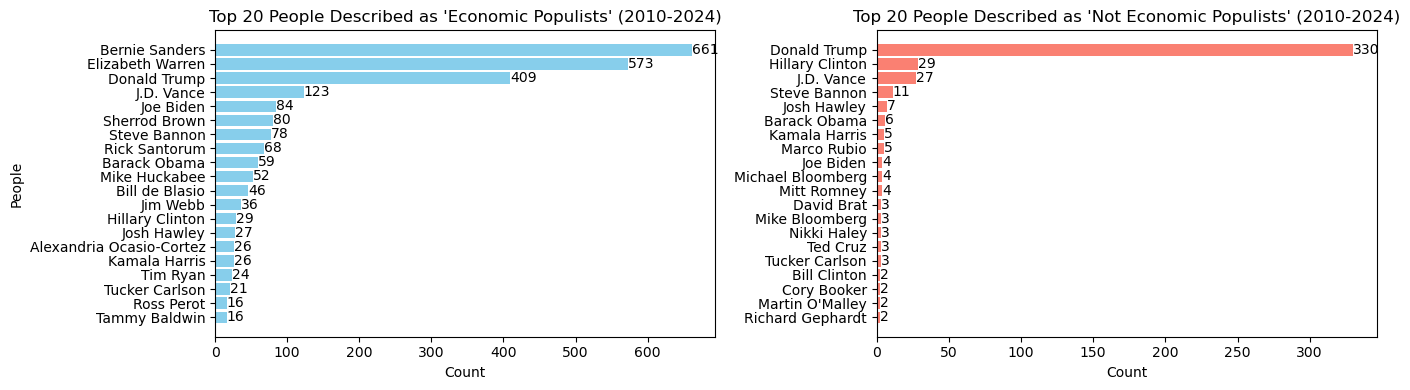

In [1071]:
# Count the frequency of each unique value in 'people'
df_person_count = df_person.groupby('people').size().reset_index(name='count')
df_not_person_count = df_not_person.groupby('people').size().reset_index(name='count')

# Sort by 'count' in descending order and take the top 20
top_20_person = df_person_count.nlargest(20, 'count')
top_20_not_person = df_not_person_count.nlargest(20, 'count')

# Create a figure
fig = plt.figure(figsize=(14, 4))

# Add subplot for df_person
ax1 = fig.add_subplot(121)  # 1 row, 2 columns, first plot
bars_person = ax1.barh(top_20_person['people'], top_20_person['count'], color='skyblue')
ax1.set_title("Top 20 People Described as 'Economic Populists' (2010-2024)")
ax1.set_xlabel('Count')
ax1.set_ylabel('People')
ax1.invert_yaxis()  # Largest at the top

# Add counts at the end of each bar for df_person
for bar in bars_person:
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.0f}', va='center', ha='left', fontsize=10)


# Add subplot for df_not_person
ax2 = fig.add_subplot(122)  # 1 row, 2 columns, second plot
bars_not_person = ax2.barh(top_20_not_person['people'], top_20_not_person['count'], color='salmon')
ax2.set_title("Top 20 People Described as 'Not Economic Populists' (2010-2024)")
ax2.set_xlabel('Count')
ax2.set_ylabel('')  # No label to avoid redundancy
ax2.invert_yaxis()  # Largest at the top

# Add counts at the end of each bar for df_not_person
for bar in bars_not_person:
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.0f}', va='center', ha='left', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Group by 'year' and calculate counts for each unique 'people' value
grouped = df_person.groupby(['Year', 'people']).size().reset_index(name='count')

# Group by 'year' and calculate counts for each unique 'people' value
grouped = df_person.groupby(['Year', 'people']).size().reset_index(name='count')

# Select the top 10 'people' values with the highest percentages for each year
top_10_per_year = grouped.sort_values('percentage', ascending=False).groupby('Year').head(5).reset_index(drop=True)

In [927]:
# Group by 'year' and calculate counts for each unique 'people' value
grouped = df_person.groupby(['Year', 'people']).size().reset_index(name='count')

In [929]:
# Calculate the percentage for each unique 'people' value within each year
grouped['percentage'] = grouped.groupby('Year')['count'].transform(lambda x: (x / x.sum()) * 100)

In [1037]:
# Select the top 10 'people' values with the highest percentages for each year
top_10_per_year = grouped.sort_values('percentage', ascending=False).groupby('Year').head(5).reset_index(drop=True)

In [1027]:
# Display the result
print(top_10_per_year)

     Year            people  count  percentage
0    2014  Elizabeth Warren     98   48.275862
1    2019  Elizabeth Warren    145   43.806647
2    2013  Elizabeth Warren     43   41.747573
3    2020    Bernie Sanders     90   40.000000
4    2016    Bernie Sanders    191   38.047809
..    ...               ...    ...         ...
115  2017    Robert Kuttner      4    1.234568
116  2017     Chuck Schumer      4    1.234568
117  2016     Mike Huckabee      5    0.996016
118  2020     Tammy Baldwin      2    0.888889
119  2020     Jesse Jackson      2    0.888889

[120 rows x 4 columns]


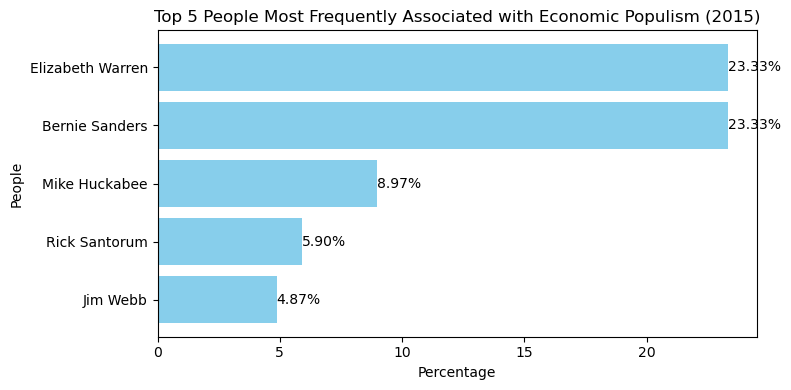

In [1069]:
# Filter the data for the year 2015
df_2015 = top_10_per_year[top_10_per_year['Year'] == 2015]

# Sort the data by percentage
df_2015_sorted = df_2015.sort_values('percentage', ascending=True)

# Create the horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(df_2015_sorted['people'], df_2015_sorted['percentage'], color='skyblue')

# Set labels and title
plt.xlabel('Percentage')
plt.ylabel('People')
plt.title('Top 5 People Most Frequently Associated with Economic Populism (2015)')

# Add percentage labels at the end of each bar
for index, value in enumerate(df_2015_sorted['percentage']):
    plt.text(value, index, f'{value:.2f}%', va='center', ha='left', color='black')

# Show the plot
plt.tight_layout()
plt.show()

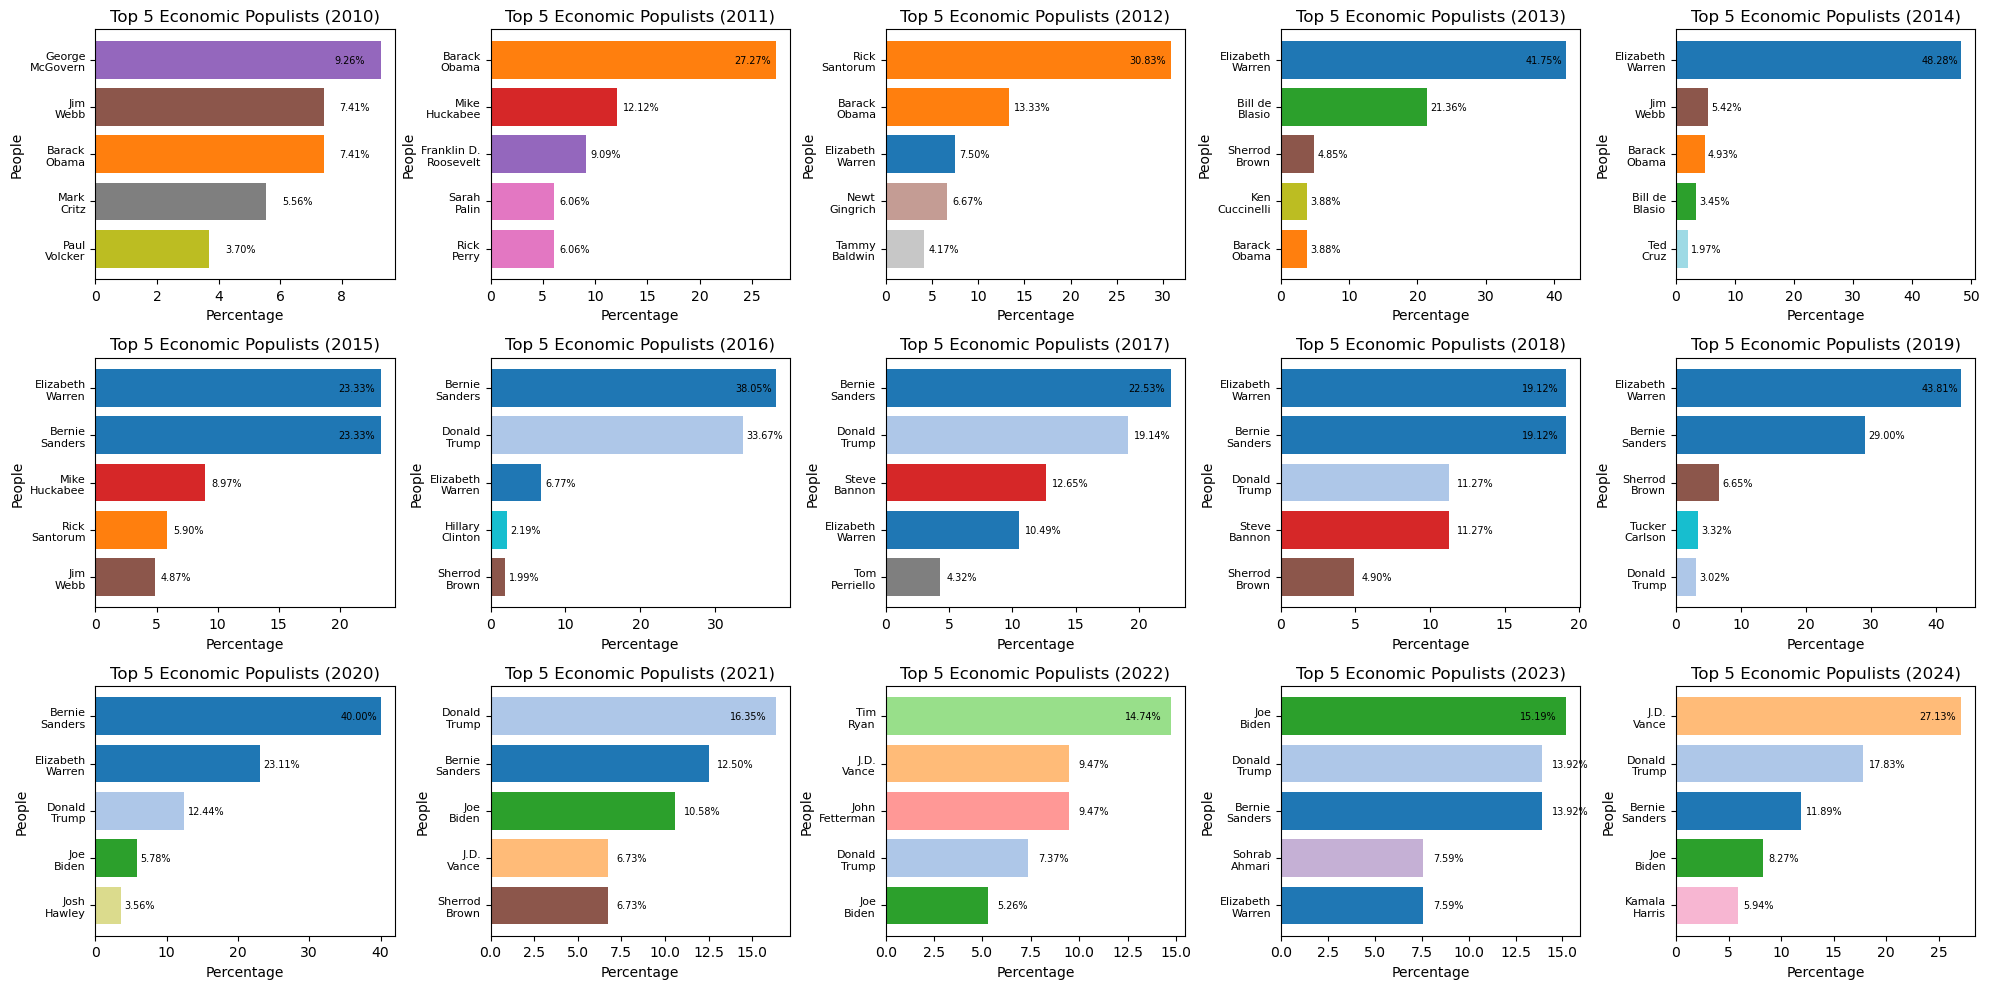

In [1079]:
# Prepare the figure and set the layout for 3 rows and 5 columns
fig = plt.figure(figsize=(20, 10))  # Keep the wider figure for more space

# Create a color map for each unique 'people' value
unique_people = top_10_per_year['people'].unique()
colormap = matplotlib.colormaps['tab20']  # Use 'tab20' colormap from matplotlib.colormaps

# Create a list of colors by applying colormap to indices
colors = [colormap(i / len(unique_people)) for i in range(len(unique_people))]

# Create a dictionary to map each 'people' value to a specific color
people_to_color = {value: colors[i] for i, value in enumerate(unique_people)}

# Loop through each year from 2010 to 2024, creating a subplot for each year
years = range(2010, 2025)
for i, year in enumerate(years):
    # Filter data for the specific year
    df_year = top_10_per_year[top_10_per_year['Year'] == year]
    df_year_sorted = df_year.sort_values('percentage', ascending=True)

    # Create a subplot for each year
    ax = fig.add_subplot(3, 5, i + 1)  # 3 rows, 5 columns, index i + 1 for positioning

    # Create the horizontal bar chart
    bars = ax.barh(df_year_sorted['people'], df_year_sorted['percentage'],
                   color=[people_to_color[person] for person in df_year_sorted['people']])

    # Set labels and title for each subplot with smaller font sizes
    ax.set_xlabel('Percentage', fontsize=10)  # Smaller font size for x-axis label
    ax.set_ylabel('People', fontsize=10)      # Smaller font size for y-axis label
    ax.set_title(f'Top 5 Economic Populists ({year})', fontsize=12)  # Smaller font size for title

    # Add percentage labels at the end of each bar, inside or outside the bar if needed
    for index, value in enumerate(df_year_sorted['percentage']):
        # Wrap text to fit inside the plot (e.g., splitting long names)
        wrapped_text = textwrap.fill(f'{value:.2f}%', width=10)
        
        # Check if the label is getting cut off at the end of the bar
        if value + 0.5 < max(df_year_sorted['percentage']):
            # If the bar is too short, move the label slightly outside the bar
            ax.text(value + 0.5, index, wrapped_text, va='center', ha='left', color='black', fontsize=7)
        else:
            # Otherwise, place the label inside the bar
            ax.text(value - 0.5, index, wrapped_text, va='center', ha='right', color='black', fontsize=7)

    # Split y-axis labels into two lines of text (splitting at the last space)
    def split_label(label):
        ''' Split y-axis labels into two lines of text (splitting at the last space)'''
        parts = label.rsplit(' ', 1)  # Split at the last space
        return '\n'.join(parts)  # Join the two parts with a newline

    # Set y-tick positions and apply the split labels
    ax.set_yticks(range(len(df_year_sorted)))  # Set tick positions
    ax.set_yticklabels([split_label(label) for label in df_year_sorted['people']])  # Set split labels

    # Make the font size for y-axis tick labels (People) smaller
    ax.tick_params(axis='y', labelsize=8)  # Set smaller font size for y-axis labels (People)

# Adjust layout to reduce left-right spacing and improve subplot arrangement
plt.tight_layout(w_pad=0.5)  # Reduce width padding between subplots
fig.subplots_adjust(left=0.03, right=0.97)  # Further adjust the left-right spacing

# Show the plot
plt.show()

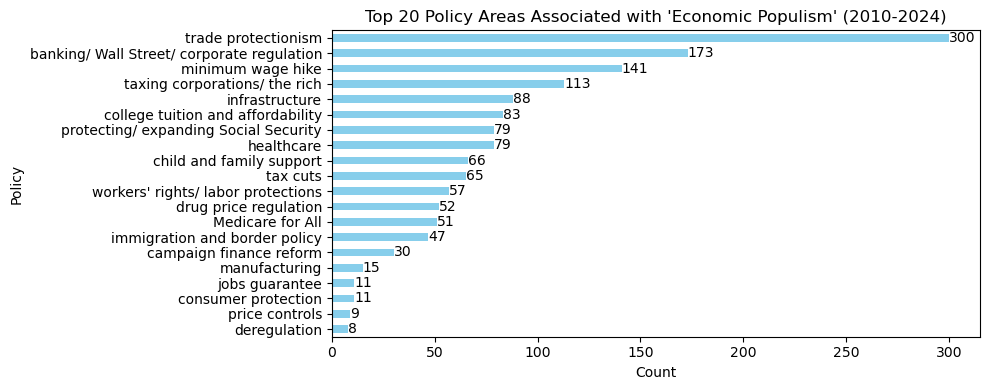

In [1137]:
# Remove 'economic populism' from the 'policy' column
df_policy_filtered = df_policy[df_policy['policy'] != 'economic populism']

# Count the frequency of each unique value in 'policy'
policy_counts = df_policy_filtered['policy'].value_counts().head(20)

# Create the horizontal bar chart
plt.figure(figsize=(10, 4))
ax = policy_counts.sort_values(ascending=True).plot(kind='barh', color='skyblue')

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Policy')
plt.title("Top 20 Policy Areas Associated with 'Economic Populism' (2010-2024)")

# Display counts at the end of each bar
for index, value in enumerate(policy_counts.sort_values(ascending=True)):
    ax.text(value, index, str(value), va='center', ha='left', color='black')

# Show the plot
plt.tight_layout()
plt.show()

In [1141]:
# Group by 'year' and calculate counts for each unique 'policy' value
grouped = df_policy.groupby(['Year', 'policy']).size().reset_index(name='count')

# Calculate the total count per year
total_counts = grouped.groupby('Year')['count'].transform('sum')

# Calculate the percentage for each 'policy' value within each year
grouped['percentage'] = (grouped['count'] / total_counts) * 100

# Select the top 5 'policy' values with the highest percentages for each year
top_5_per_year = grouped.sort_values('percentage', ascending=False).groupby('Year').head(5).reset_index(drop=True)

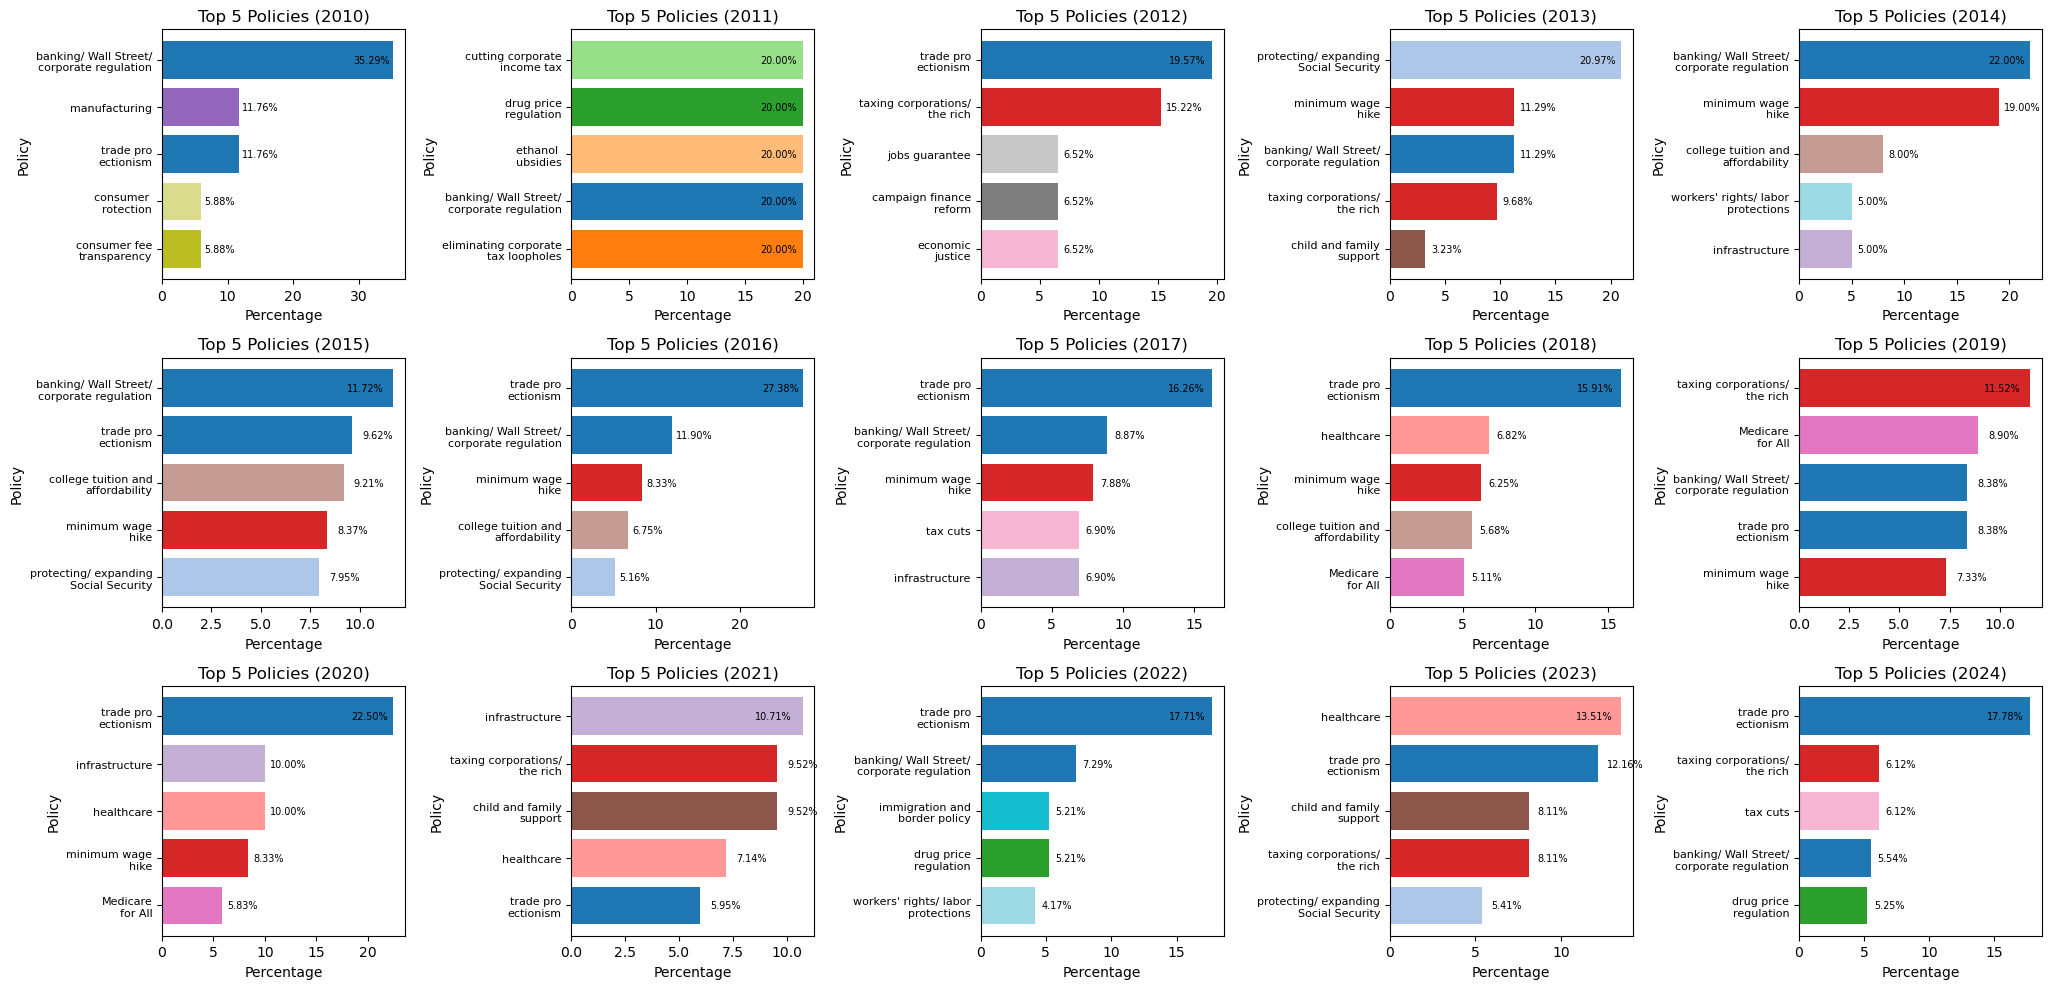

In [1147]:
# Prepare the figure and set the layout for 3 rows and 5 columns
fig = plt.figure(figsize=(20, 10))  # Keep the wider figure for more space

# Create a color map for each unique 'policy' value
unique_policy = top_5_per_year['policy'].unique()
colormap = matplotlib.colormaps['tab20']  # Updated way to access colormap

# Create a list of colors by applying colormap to indices
colors = [colormap(i / len(unique_policy)) for i in range(len(unique_policy))]

# Create a dictionary to map each 'policy' value to a specific color
policy_to_color = {value: colors[i] for i, value in enumerate(unique_policy)}

# Loop through each year from 2010 to 2024, creating a subplot for each year
years = range(2010, 2025)
for i, year in enumerate(years):
    # Filter data for the specific year
    df_year = top_5_per_year[top_5_per_year['Year'] == year]
    df_year_sorted = df_year.sort_values('percentage', ascending=True)

    # Create a subplot for each year
    ax = fig.add_subplot(3, 5, i + 1)  # 3 rows, 5 columns, index i + 1 for positioning

    # Create the horizontal bar chart
    bars = ax.barh(df_year_sorted['policy'], df_year_sorted['percentage'],
                   color=[policy_to_color[policy] for policy in df_year_sorted['policy']])

    # Set labels and title for each subplot with smaller font sizes
    ax.set_xlabel('Percentage', fontsize=10)  # Smaller font size for x-axis label
    ax.set_ylabel('Policy', fontsize=10)      # Smaller font size for y-axis label
    ax.set_title(f'Top 5 Policies ({year})', fontsize=12)  # Smaller font size for title

    # Add percentage labels at the end of each bar, inside or outside the bar if needed
    for index, value in enumerate(df_year_sorted['percentage']):
        # Wrap text to fit inside the plot (e.g., splitting long names)
        wrapped_text = textwrap.fill(f'{value:.2f}%', width=10)
        
        # Check if the label is getting cut off at the end of the bar
        if value + 0.5 < max(df_year_sorted['percentage']):
            # If the bar is too short, move the label slightly outside the bar
            ax.text(value + 0.5, index, wrapped_text, va='center', ha='left', color='black', fontsize=7)
        else:
            # Otherwise, place the label inside the bar
            ax.text(value - 0.5, index, wrapped_text, va='center', ha='right', color='black', fontsize=7)

    # Split y-axis labels into two lines of text (splitting at the space closest to the middle)
    def split_label(label):
        ''' Split y-axis labels into two lines of text (splitting at the space closest to the middle)'''
        if len(label) <= 15:  # Do not split if label length is 15 characters or fewer
            return label
        
        mid_point = len(label) // 2  # Find the midpoint of the label
        space_index = label.find(' ', mid_point)  # Find the first space after the midpoint
        
        # If no space is found, split at the midpoint directly
        if space_index == -1:
            space_index = mid_point
        
        return '\n'.join([label[:space_index], label[space_index + 1:]])  # Split at the space

    # Set y-tick positions and apply the split labels
    ax.set_yticks(range(len(df_year_sorted)))  # Set tick positions
    ax.set_yticklabels([split_label(label) for label in df_year_sorted['policy']])  # Set split labels

    # Make the font size for y-axis tick labels (Policy) smaller
    ax.tick_params(axis='y', labelsize=8)  # Set smaller font size for y-axis labels (Policy)

# Adjust layout to reduce left-right spacing and improve subplot arrangement
plt.tight_layout(w_pad=0.5)  # Reduce width padding between subplots
fig.subplots_adjust(left=0.03, right=0.97)  # Further adjust the left-right spacing

# Show the plot
plt.show()

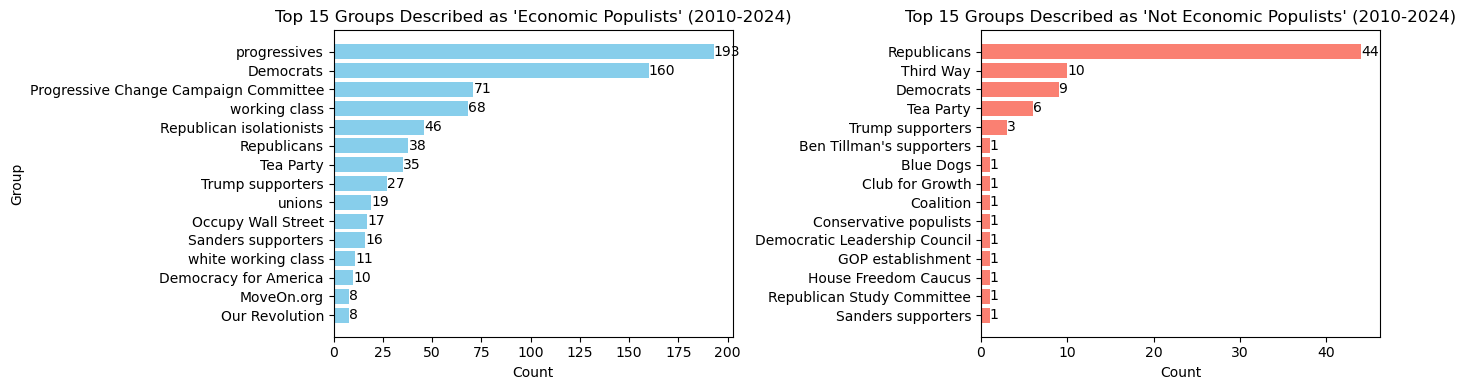

In [1195]:
# Remove the value 'economic populists' from 'group' in df_group
df_group_2 = df_group[df_group['group'] != 'economic populists']

# Remove the value 'Trump' from 'group' in df_not_group
df_not_group_2 = df_not_group[df_not_group['group'] != 'Trump']

# Count the frequency of each unique value in 'group'
df_group_count = df_group_2.groupby('group').size().reset_index(name='count')
df_not_group_count = df_not_group_2.groupby('group').size().reset_index(name='count')

# Sort by 'count' in descending order and take the top 15
top_15_group = df_group_count.nlargest(15, 'count')
top_15_not_group = df_not_group_count.nlargest(15, 'count')

# Create a figure
fig = plt.figure(figsize=(14, 4))

# Add subplot for df_group
ax1 = fig.add_subplot(121)  # 1 row, 2 columns, first plot
bars_group = ax1.barh(top_15_group['group'], top_15_group['count'], color='skyblue')
ax1.set_title("Top 15 Groups Described as 'Economic Populists' (2010-2024)")
ax1.set_xlabel('Count')
ax1.set_ylabel('Group')
ax1.invert_yaxis()  # Largest at the top

# Add counts at the end of each bar for df_group
for bar in bars_group:
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.0f}', va='center', ha='left', fontsize=10)


# Add subplot for df_not_group
ax2 = fig.add_subplot(122)  # 1 row, 2 columns, second plot
bars_not_group = ax2.barh(top_15_not_group['group'], top_15_not_group['count'], color='salmon')
ax2.set_title("Top 15 Groups Described as 'Not Economic Populists' (2010-2024)")
ax2.set_xlabel('Count')
ax2.set_ylabel('')  # No label to avoid redundancy
ax2.invert_yaxis()  # Largest at the top

# Add counts at the end of each bar for df_not_group
for bar in bars_not_group:
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.0f}', va='center', ha='left', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

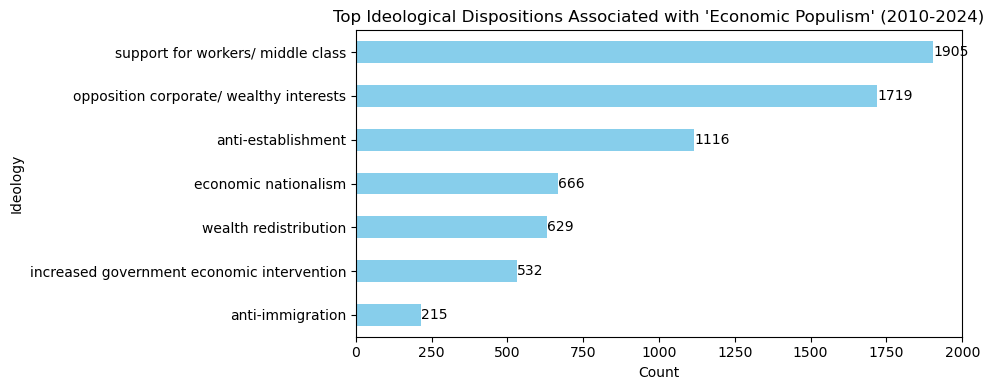

In [1175]:
# Recode specific values in the 'ideology' column
df_ideology['ideology'] = df_ideology['ideology'].replace({
    'workers/middle class': 'support for workers/ middle class',
    'opposition corporate/wealthy interests': 'opposition corporate/ wealthy interests',
    'gov intervention': 'increased government economic intervention'
})

# Remove 'none' and 'anti-corruption' from the 'ideology' column
df_ideology_filtered = df_ideology[~df_ideology['ideology'].isin(['none', 'anti-corruption'])]

# Count the frequency of each unique value in 'ideology'
ideology_counts = df_ideology_filtered['ideology'].value_counts().head(10)

# Create the horizontal bar chart
plt.figure(figsize=(10, 4))
ax = ideology_counts.sort_values(ascending=True).plot(kind='barh', color='skyblue')

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Ideology')
plt.title("Top Ideological Dispositions Associated with 'Economic Populism' (2010-2024)")

# Display counts at the end of each bar
for index, value in enumerate(ideology_counts.sort_values(ascending=True)):
    ax.text(value, index, str(value), va='center', ha='left', color='black')

# Show the plot
plt.tight_layout()
plt.show()

In [1181]:
# Group by 'year' and calculate counts for each unique 'ideology' value
grouped = df_ideology_filtered.groupby(['Year', 'ideology']).size().reset_index(name='count')

# Calculate the total count per year
total_counts = grouped.groupby('Year')['count'].transform('sum')

# Calculate the percentage for each 'ideology' value within each year
grouped['percentage'] = (grouped['count'] / total_counts) * 100

# Select the top 5 'ideology' values with the highest percentages for each year
top_5_per_year = grouped.sort_values('percentage', ascending=False).groupby('Year').head(5).reset_index(drop=True)

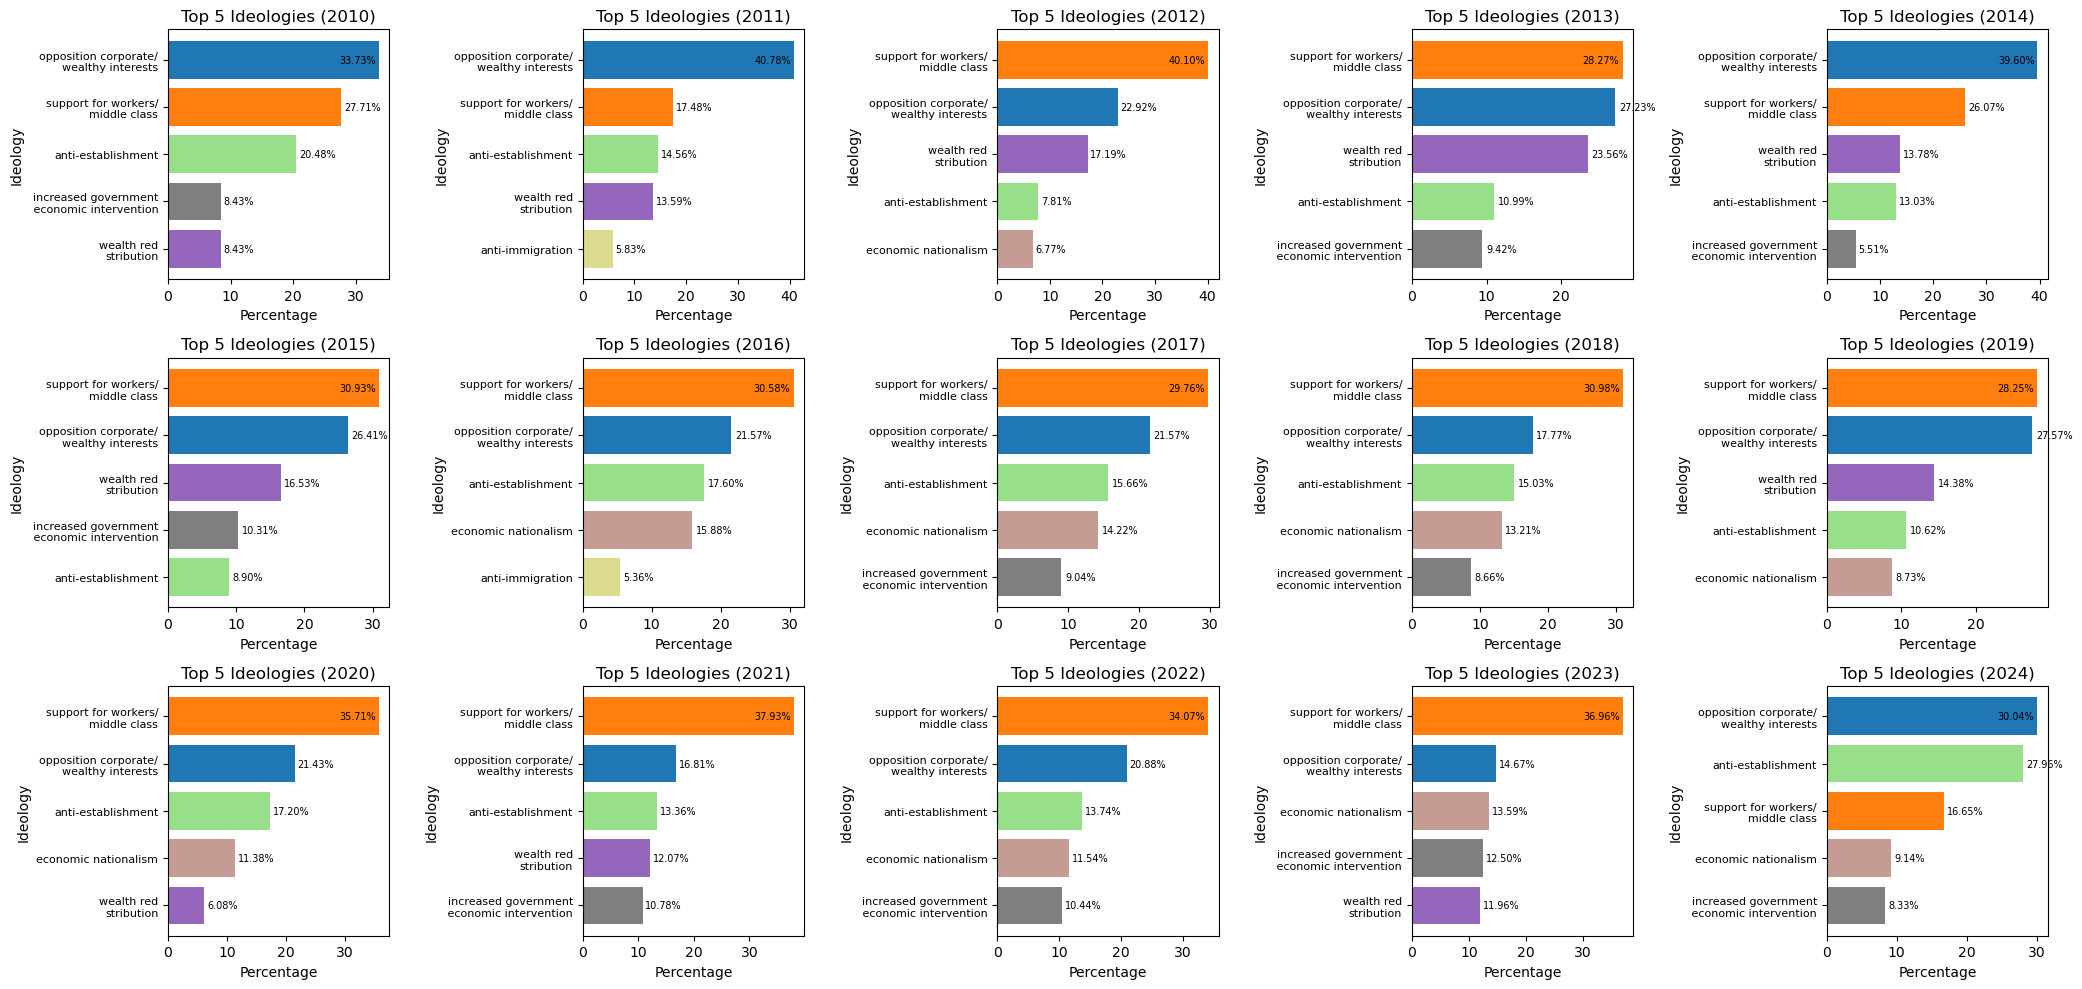

In [1191]:
# Prepare the figure and set the layout for 3 rows and 5 columns
fig = plt.figure(figsize=(20, 10))  # Keep the wider figure for more space

# Create a color map for each unique 'ideology' value
unique_ideology = top_5_per_year['ideology'].unique()
colormap = matplotlib.colormaps['tab20']  # Updated way to access colormap

# Create a list of colors by applying colormap to indices
colors = [colormap(i / len(unique_ideology)) for i in range(len(unique_ideology))]

# Create a dictionary to map each 'ideology' value to a specific color
ideology_to_color = {value: colors[i] for i, value in enumerate(unique_ideology)}

# Loop through each year from 2010 to 2024, creating a subplot for each year
years = range(2010, 2025)
for i, year in enumerate(years):
    # Filter data for the specific year
    df_year = top_5_per_year[top_5_per_year['Year'] == year]
    df_year_sorted = df_year.sort_values('percentage', ascending=True)

    # Create a subplot for each year
    ax = fig.add_subplot(3, 5, i + 1)  # 3 rows, 5 columns, index i + 1 for positioning

    # Create the horizontal bar chart
    bars = ax.barh(df_year_sorted['ideology'], df_year_sorted['percentage'],
                   color=[ideology_to_color[ideology] for ideology in df_year_sorted['ideology']])

    # Set labels and title for each subplot with smaller font sizes
    ax.set_xlabel('Percentage', fontsize=10)  # Smaller font size for x-axis label
    ax.set_ylabel('Ideology', fontsize=10)    # Smaller font size for y-axis label
    ax.set_title(f'Top 5 Ideologies ({year})', fontsize=12)  # Smaller font size for title

    # Add percentage labels at the end of each bar, inside or outside the bar if needed
    for index, value in enumerate(df_year_sorted['percentage']):
        # Wrap text to fit inside the plot (e.g., splitting long names)
        wrapped_text = textwrap.fill(f'{value:.2f}%', width=10)
        
        # Check if the label is getting cut off at the end of the bar
        if value + 0.5 < max(df_year_sorted['percentage']):
            # If the bar is too short, move the label slightly outside the bar
            ax.text(value + 0.5, index, wrapped_text, va='center', ha='left', color='black', fontsize=7)
        else:
            # Otherwise, place the label inside the bar
            ax.text(value - 0.5, index, wrapped_text, va='center', ha='right', color='black', fontsize=7)

    # Split y-axis labels into two lines of text (splitting at 'increased government economic intervention' specifically)
    def split_label(label):
        ''' Split y-axis labels into two lines of text if it's 'increased government economic intervention' '''
        if label == 'increased government economic intervention':
            return 'increased government\n economic intervention'
        if len(label) <= 20:  # Do not split if label length is 20 characters or fewer
            return label
        
        mid_point = len(label) // 2  # Find the midpoint of the label
        space_index = label.find(' ', mid_point)  # Find the first space after the midpoint
        
        # If no space is found, split at the midpoint directly
        if space_index == -1:
            space_index = mid_point
        
        return '\n'.join([label[:space_index], label[space_index + 1:]])  # Split at the space

    # Set y-tick positions and apply the split labels
    ax.set_yticks(range(len(df_year_sorted)))  # Set tick positions
    ax.set_yticklabels([split_label(label) for label in df_year_sorted['ideology']])  # Set split labels

    # Make the font size for y-axis tick labels (Ideology) smaller
    ax.tick_params(axis='y', labelsize=8)  # Set smaller font size for y-axis labels (Ideology)

# Adjust layout to reduce left-right spacing and improve subplot arrangement
plt.tight_layout(w_pad=0.5)  # Reduce width padding between subplots
fig.subplots_adjust(left=0.03, right=0.97)  # Further adjust the left-right spacing

# Show the plot
plt.show()

## Final Takeaways/Analysis

### People: 

The media tends to label the usual suspects from insurgent "anti-elite" wings of their respective political parties as economic populists; Bernie Sanders, Elizabeth Warren, Donald Trump, and J.D. Vance top the list. Other notable figures include Sherrod Brown, Steve Bannon, Rick Santorum, Mike Huckabee, Bill de Blasio, Jim Webb, Josh Hawley, AOC, Tim Ryan, Tucker Carlson, Ross Perot, Tammy Baldwin, and Marco Rubio. 

The term "economic populism" is also thrown around quite loosely to describe specific policy concessions or messaging campaigns made by more centrist political figures (particularly those affiliated with the Democratic Party, e.g., Joe Biden, Hillary Clinton, Barack Obama) to appeal to working-class voters. Additionally, the media is quite divided as to whether or not specific political figures, ususally Republicans in Trump's orbit, are sincere in their overtures to economic populism. Trump himself is referred to as being antithetical to the cause of economic populism almost half as many times as he is referred to as a sincere economic populist.

When examining the top 5 political figures referred to as "economic populists" over time, we can see the rise and decline of various politicians/pundits in the news cycle. The most interesting finding is in the types of Republican politicians that are associated with "economic populism" before and after Trump's first presidential campaign. Early in this dataset, figures like Rick Santorum and Mike Huckabee represent the Republican "economic populist" camp. Both figures were strongly associated with Christian conservatism and the Tea Party movement. While they are both figures who were skeptical of free trade before this position was mainstream in the Republican Party and frequently showed disdain for economic elites, both espoused an extreme economic libertarian ideology and wanted to limit the government's role in the economy as much as possible (even going so far as to profess that the federal minimum wage should be abolished and that Social Security benefits should be cut). The latter policies stand in stark contrast with the professed policy preferences of the "economic populists" of the post-Trump Republican Party (i.e., J.D. Vance, Josh Hawley, Marco Rubio). Such senators have introduced/supported legislation concerning issues like raising the federal minimum wage, anti-trust, stimulus checks, and the child tax credit which go against traditional conservative orthodoxy and would have been unthinkable for a Republican to support in the early 2010s.

### Policy:

The following broad policy agendas are most associated with "economic populism" in my data set: trade protectionism, regulation of banks/corporations, raising the federal minimum wage, increasing taxes on corporations and the rich, infrastucture, college affordability, protecting/expanding Social Security, healthcare reform, and child and family support. Over time analysis reveals that trade protectionism and the regulation of banks/corporations remain the most popular policy agendas associated with "economic populism" throughout the entirety of the data set. However, other policy trends can also be observed. For instance, during the 2020 presidential election and in the first year of the Biden presidency, infrastructure became a top policy issue associated with "economic populism", likely because of Biden's campaign promise to "Build Back Better" and the subsequent introduction and passage of the Bipartisan Infrastructure Law in 2021. "Child and family support" also rose in the rankings during the 2020s, likely due to the expansion of the child tax credit and subsequent efforts to make this increase permanent.

### Partisan Factions/Interest Groups:

Progressive Democratic groups (including PCCC, Democracy for America, MoveOn.org, and Our Revolution) are by far the partisan faction that is most associated with "economic populism". There is also clearly a class-based element as well; the working class, white working class, and unions are amongst the most frequently cited groups associated with "economic populism". However, some partisan factions associated with the Republican Party also feauture, namely Republican isolationists and the Tea Party. The Tea Party (on the right) and Occupy Wall Street (on the left) both expressed indignation at economic elites in the wake of the Global Financial Crisis, laying the foundations for the current economic populist zeitgeist. 

Once again, the sincerity of Republicans' "economic populism" is questioned in the media. Centrist groups associated with the Democratic Party, such as the think tank Third Way, are decidedly not economically populist as well. Because the partisan faction/group data set was quite small, I decided against showing over time visual analysis which was not all that revealing.

### Ideology:

Because political ideology can be so expansive, I gave Claude a set of seven pre-defined categories from which to choose from in coding how "economic populism" was defined ideologically in each media source. Support for workers and the middle class and opposition to corporate/wealthy interests were the top two ideological codes assigned to my data, and these two categories remained consistently at the top of the media's definition of economic populism over time. This finding demonstrates that the media's definition of "economic populism" is largely in line with scholarly definitions of populism (Mudde 2004) which emphasize the vertical polarization between a common "people" and "the elite" and the fundamental anatagonism that exists between the two. 